In [22]:
import numpy as np

def design_fir_lowpass(num_taps, cutoff_freq, sample_rate, window_func=np.hamming):
    """
    Designs FIR low-pass filter coefficients using the windowing method.

    Args:
        num_taps (int): Number of filter coefficients (taps).
        cutoff_freq (float): Cutoff frequency in Hz.
        sample_rate (float): Sampling rate in Hz.
        window_func (callable): Window function to apply (e.g., np.hamming, np.blackman).

    Returns:
        numpy.ndarray: Array of filter coefficients.
    """
    nyquist_freq = 0.5 * sample_rate
    normalized_cutoff = cutoff_freq / nyquist_freq

    # Create ideal low-pass filter impulse response (sinc function)
    t = np.arange(num_taps) - (num_taps - 1) / 2
    h_ideal = np.sinc(2 * normalized_cutoff * t)

    # Apply window function
    window = window_func(num_taps)
    h = h_ideal * window

    # Normalize coefficients to ensure unity gain at DC
    h /= np.sum(h)
    return h

$$
y[n] = \sum
$$

In [23]:
def apply_fir_filter(signal, filter_coefficients):
    """
    Applies an FIR filter to a signal using convolution.

    Args:
        signal (numpy.ndarray): Input signal.
        filter_coefficients (numpy.ndarray): FIR filter coefficients.

    Returns:
        numpy.ndarray: Filtered signal.
    """
    return np.convolve(signal, filter_coefficients, mode='valid')

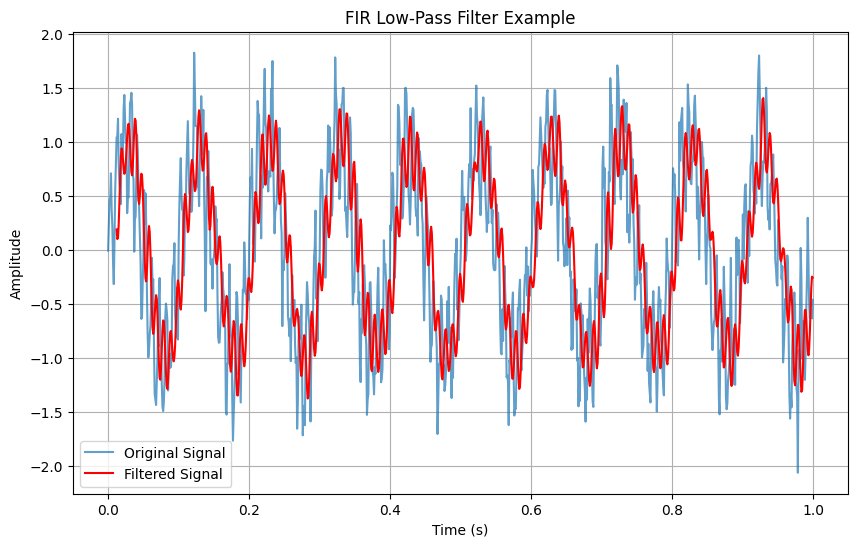

In [24]:
import matplotlib.pyplot as plt

# Generate a test signal
sample_rate = 1000  # Hz
duration = 1.0      # seconds
t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
signal = np.sin(2 * np.pi * 10 * t) + 0.5 * np.sin(2 * np.pi * 100 * t) + 0.2 * np.random.randn(len(t))

# Design the filter
# num_taps = 51
num_taps = 13
cutoff_freq = 50  # Hz
fir_coefficients = design_fir_lowpass(num_taps, cutoff_freq, sample_rate)

# Apply the filter
filtered_signal = apply_fir_filter(signal, fir_coefficients)

# Plotting results
plt.figure(figsize=(10, 6))
plt.plot(t, signal, label='Original Signal', alpha=0.7)
# Adjust time axis for filtered signal due to 'valid' mode in convolve
plt.plot(t[num_taps-1:], filtered_signal, label='Filtered Signal', color='red')
plt.title('FIR Low-Pass Filter Example')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
fir_coefficients

array([-2.71974830e-03,  1.20382186e-18,  1.58085370e-02,  5.94087100e-02,
        1.27068630e-01,  1.91410110e-01,  2.18047524e-01,  1.91410110e-01,
        1.27068630e-01,  5.94087100e-02,  1.58085370e-02,  1.20382186e-18,
       -2.71974830e-03])

In [26]:
def float_to_fixed_point(coeffs, int_bits=1, frac_bits=15):
    """
    Convert floating-point coefficients to 16-bit fixed-point representation.
    
    Args:
        coeffs (numpy.ndarray): Floating-point coefficients
        int_bits (int): Number of integer bits (default: 1 for sign + 0 integer bits)
        frac_bits (int): Number of fractional bits (default: 15)
    
    Returns:
        tuple: (fixed_point_coeffs, scale_factor)
            - fixed_point_coeffs: 16-bit signed integer array
            - scale_factor: scaling factor used (2^frac_bits)
    """
    # Calculate scale factor
    scale_factor = 2**frac_bits
    
    # Scale and round to nearest integer
    scaled_coeffs = np.round(coeffs * scale_factor).astype(np.int16)
    
    # Check for overflow
    max_val = 2**(15) - 1  # Maximum positive value for 16-bit signed
    min_val = -2**(15)     # Maximum negative value for 16-bit signed
    
    if np.any(scaled_coeffs > max_val) or np.any(scaled_coeffs < min_val):
        print(f"Warning: Coefficients overflow 16-bit range!")
        print(f"Max coefficient: {np.max(scaled_coeffs)}, Min coefficient: {np.min(scaled_coeffs)}")
        # Clip to valid range
        scaled_coeffs = np.clip(scaled_coeffs, min_val, max_val)
    
    return scaled_coeffs, scale_factor

# Convert coefficients to 16-bit fixed point (Q1.15 format)
fixed_coeffs, scale = float_to_fixed_point(fir_coefficients)

print(f"Scale factor: {scale}")
print(f"Fixed-point coefficients (16-bit signed integers):")
print(fixed_coeffs)
print(f"\nCoefficient range: {np.min(fixed_coeffs)} to {np.max(fixed_coeffs)}")

# Verify conversion by converting back to float
recovered_coeffs = fixed_coeffs.astype(np.float64) / scale
max_error = np.max(np.abs(fir_coefficients - recovered_coeffs))
print(f"Maximum quantization error: {max_error:.2e}")

Scale factor: 32768
Fixed-point coefficients (16-bit signed integers):
[ -89    0  518 1947 4164 6272 7145 6272 4164 1947  518    0  -89]

Coefficient range: -89 to 7145
Maximum quantization error: 9.01e-06


In [27]:
def export_coefficients_for_hardware(fixed_coeffs, format_type='verilog'):
    """
    Export fixed-point coefficients in various hardware-friendly formats.
    
    Args:
        fixed_coeffs (numpy.ndarray): 16-bit fixed-point coefficients
        format_type (str): Output format - 'verilog', 'c_array', 'hex', 'binary'
    
    Returns:
        str: Formatted coefficient string
    """
    if format_type == 'verilog':
        # SystemVerilog array format
        coeffs_str = "parameter logic signed [15:0] fir_coeffs[0:{}] = '{{\n".format(len(fixed_coeffs)-1)
        for i, coeff in enumerate(fixed_coeffs):
            # Convert to Python int to avoid overflow issues
            coeff_int = int(coeff)
            # Convert to unsigned 16-bit representation for hex display
            if coeff_int >= 0:
                unsigned_val = coeff_int
            else:
                unsigned_val = coeff_int + 65536  # Two's complement conversion
            hex_val = f"16'h{unsigned_val:04X}"
            coeffs_str += f"    {hex_val}" + ("," if i < len(fixed_coeffs)-1 else "") + f"  // {coeff_int}\n"
        coeffs_str += "};"
        return coeffs_str
    
    elif format_type == 'c_array':
        # C array format
        coeffs_str = "const int16_t fir_coeffs[] = {\n"
        for i, coeff in enumerate(fixed_coeffs):
            coeffs_str += f"    {int(coeff)}" + ("," if i < len(fixed_coeffs)-1 else "") + "\n"
        coeffs_str += "};"
        return coeffs_str
    
    elif format_type == 'hex':
        # Hex values only
        hex_values = []
        for coeff in fixed_coeffs:
            coeff_int = int(coeff)
            if coeff_int >= 0:
                hex_values.append(f"0x{coeff_int:04X}")
            else:
                unsigned_val = coeff_int + 65536
                hex_values.append(f"0x{unsigned_val:04X}")
        return ", ".join(hex_values)
    
    elif format_type == 'binary':
        # Binary format (16-bit two's complement)
        binary_values = []
        for coeff in fixed_coeffs:
            coeff_int = int(coeff)
            if coeff_int >= 0:
                binary_values.append(f"{coeff_int:016b}")
            else:
                unsigned_val = coeff_int + 65536
                binary_values.append(f"{unsigned_val:016b}")
        return "\n".join(binary_values)

# Generate different formats
print("=== SystemVerilog Format ===")
print(export_coefficients_for_hardware(fixed_coeffs, 'verilog'))

print("\n=== C Array Format ===")
print(export_coefficients_for_hardware(fixed_coeffs, 'c_array'))

print(f"\n=== Hex Format ===")
print(export_coefficients_for_hardware(fixed_coeffs, 'hex'))

=== SystemVerilog Format ===
parameter logic signed [15:0] fir_coeffs[0:12] = '{
    16'hFFA7,  // -89
    16'h0000,  // 0
    16'h0206,  // 518
    16'h079B,  // 1947
    16'h1044,  // 4164
    16'h1880,  // 6272
    16'h1BE9,  // 7145
    16'h1880,  // 6272
    16'h1044,  // 4164
    16'h079B,  // 1947
    16'h0206,  // 518
    16'h0000,  // 0
    16'hFFA7  // -89
};

=== C Array Format ===
const int16_t fir_coeffs[] = {
    -89,
    0,
    518,
    1947,
    4164,
    6272,
    7145,
    6272,
    4164,
    1947,
    518,
    0,
    -89
};

=== Hex Format ===
0xFFA7, 0x0000, 0x0206, 0x079B, 0x1044, 0x1880, 0x1BE9, 0x1880, 0x1044, 0x079B, 0x0206, 0x0000, 0xFFA7


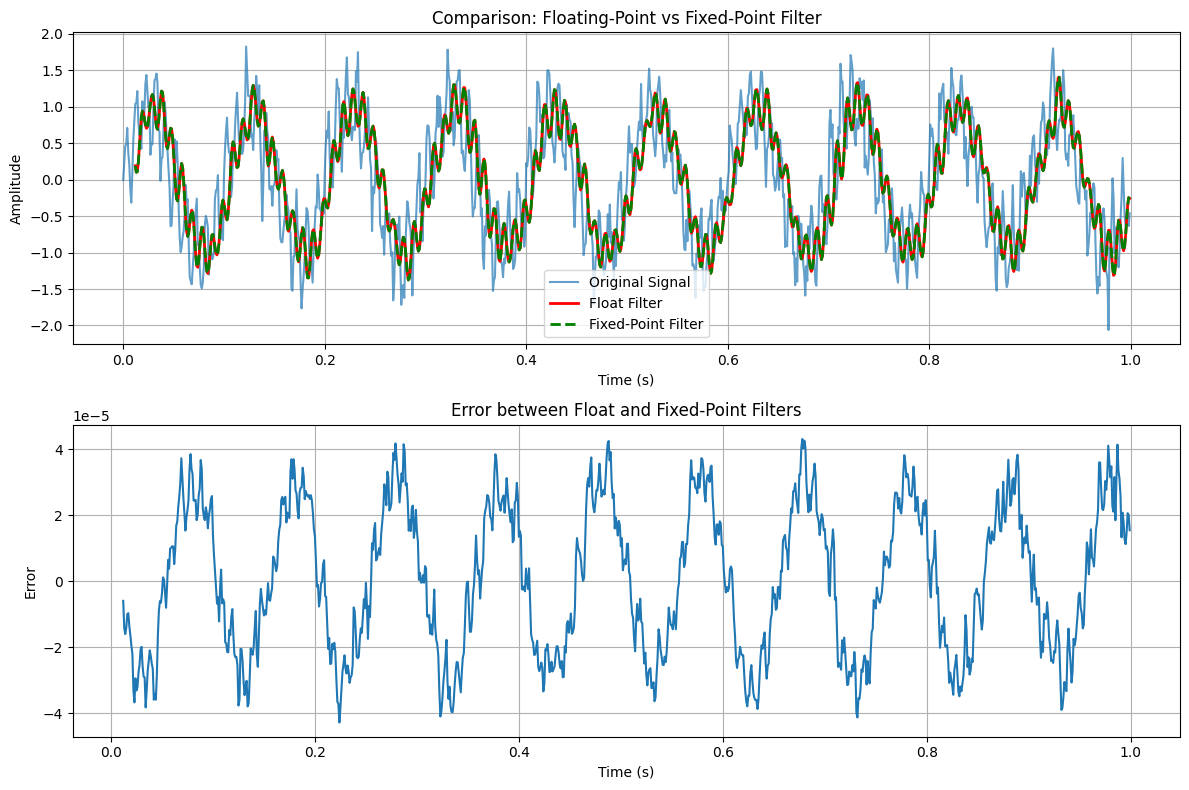

Maximum error between float and fixed-point filters: 4.31e-05
RMS error: 2.22e-05


In [28]:
def apply_fixed_point_filter(signal, fixed_coeffs, scale_factor):
    """
    Apply fixed-point FIR filter to a signal.
    
    Args:
        signal (numpy.ndarray): Input signal
        fixed_coeffs (numpy.ndarray): Fixed-point filter coefficients
        scale_factor (float): Scale factor used in fixed-point conversion
    
    Returns:
        numpy.ndarray: Filtered signal (converted back to floating point)
    """
    # Convert signal to fixed-point (simulate ADC)
    signal_fixed = np.round(signal * scale_factor).astype(np.int32)
    
    # Apply convolution using fixed-point arithmetic
    filtered_fixed = np.convolve(signal_fixed, fixed_coeffs.astype(np.int32), mode='valid')
    
    # Convert back to floating point (simulate DAC)
    # Note: We divide by scale_factor twice because both signal and coeffs were scaled
    filtered_float = filtered_fixed.astype(np.float64) / (scale_factor * scale_factor)
    
    return filtered_float

# Test the fixed-point filter
fixed_filtered = apply_fixed_point_filter(signal, fixed_coeffs, scale)
float_filtered = apply_fir_filter(signal, fir_coefficients)

# Compare results
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(t, signal, label='Original Signal', alpha=0.7)
plt.plot(t[num_taps-1:], float_filtered, label='Float Filter', color='red', linewidth=2)
plt.plot(t[num_taps-1:], fixed_filtered, label='Fixed-Point Filter', color='green', linestyle='--', linewidth=2)
plt.title('Comparison: Floating-Point vs Fixed-Point Filter')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
error = float_filtered - fixed_filtered
plt.plot(t[num_taps-1:], error)
plt.title('Error between Float and Fixed-Point Filters')
plt.xlabel('Time (s)')
plt.ylabel('Error')
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Maximum error between float and fixed-point filters: {np.max(np.abs(error)):.2e}")
print(f"RMS error: {np.sqrt(np.mean(error**2)):.2e}")

In [29]:
signal

array([-0.00554905,  0.23555604,  0.46286514,  0.48352775,  0.7103054 ,
        0.37215437,  0.21164939, -0.12249401, -0.31588136,  0.07520137,
        0.54730566,  0.79000936,  1.0424327 ,  1.05239458,  1.21550088,
        0.79922868,  0.61708999,  0.55750657,  0.425469  ,  1.0738998 ,
        0.80953221,  0.93121908,  1.31381534,  1.43570896,  1.20846674,
        0.99236382,  1.0269263 ,  0.34103568,  0.49722593,  0.48531585,
        0.95292024,  1.35912108,  1.38066023,  1.45576615,  1.33098691,
        0.70215643,  0.65242525, -0.01603275,  0.27907695,  0.31349591,
        0.70843704,  1.06917872,  0.91996133,  0.62843767,  0.38983187,
        0.16273139, -0.10884199, -0.63829803, -0.6265239 , -0.30471172,
       -0.07459926,  0.55448708,  0.24267314,  0.52443067,  0.24829266,
       -0.37299304, -0.7755066 , -0.99434225, -0.92247367, -0.78412326,
       -0.70333417, -0.47774351, -0.07234878, -0.31277312, -0.27097162,
       -0.86482608, -1.33412851, -1.38922951, -1.43558898, -1.21

Current signal characteristics:
Signal range: -2.063 to 1.827
Signal mean: -0.008
Signal std: 0.808
Signal length: 1000

After scaling and offset for 8-bit ADC:
Scaled signal range: -0.000 to 3.112
ADC codes range: 0 to 240
Quantized signal range: 0.000V to 3.106V


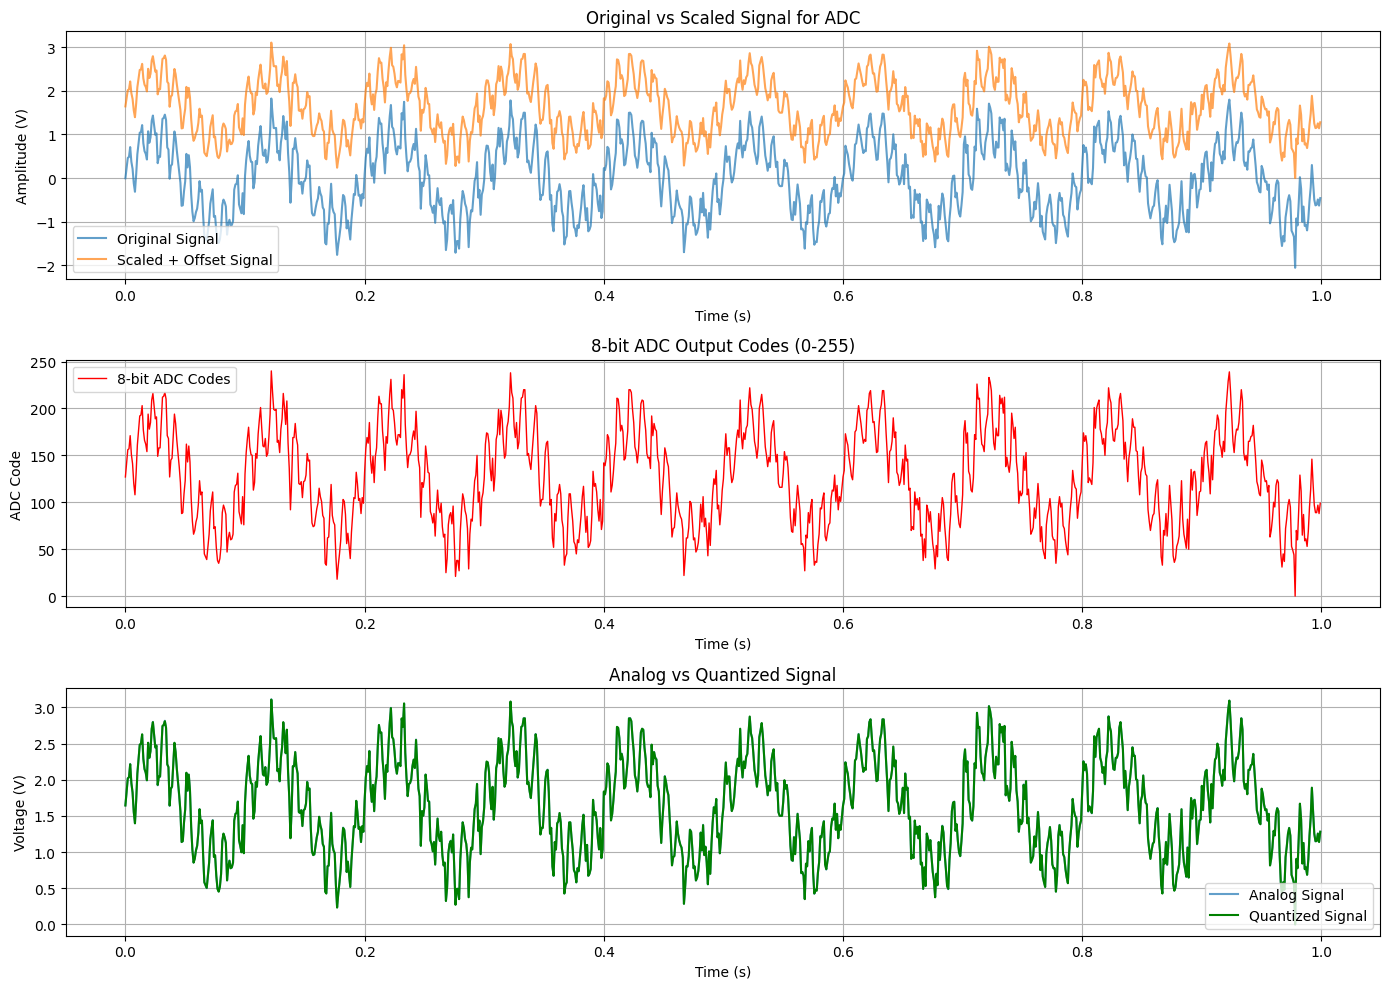


Quantization characteristics:
Quantization step size: 0.0129V
Max quantization error: 0.0065V
RMS quantization error: 0.0038V


In [30]:
# Analyze current signal characteristics
print("Current signal characteristics:")
print(f"Signal range: {np.min(signal):.3f} to {np.max(signal):.3f}")
print(f"Signal mean: {np.mean(signal):.3f}")
print(f"Signal std: {np.std(signal):.3f}")
print(f"Signal length: {len(signal)}")

# For an 8-bit ADC, we have 256 levels (0 to 255)
# Typical voltage range for FPGA ADCs is 0V to 3.3V or 0V to 1.8V
# Let's assume 0V to 3.3V range

def simulate_8bit_adc(analog_signal, vref=3.3, offset=0.0):
    """
    Simulate an 8-bit ADC conversion for FPGA design.
    
    Args:
        analog_signal (numpy.ndarray): Input analog signal
        vref (float): ADC reference voltage (default: 3.3V)
        offset (float): DC offset to add to signal (default: 0.0V)
    
    Returns:
        tuple: (adc_codes, quantized_signal)
            - adc_codes: 8-bit integer values (0-255)
            - quantized_signal: Quantized analog signal
    """
    # Add DC offset to ensure signal is positive (ADCs typically can't handle negative voltages)
    offset_signal = analog_signal + offset
    
    # Clip to ADC input range
    clipped_signal = np.clip(offset_signal, 0.0, vref)
    
    # Convert to 8-bit codes (0-255)
    adc_codes = np.round(clipped_signal * 255.0 / vref).astype(np.uint8)
    
    # Convert back to quantized analog signal
    quantized_signal = adc_codes.astype(np.float64) * vref / 255.0
    
    return adc_codes, quantized_signal

# Create 8-bit ADC version of signal
# First, scale and offset the signal to fit in ADC range
signal_scaled = signal * 0.8  # Scale down to prevent clipping
signal_offset = 1.65  # Add DC offset (middle of 3.3V range)

adc_codes, adc_signal = simulate_8bit_adc(signal_scaled, vref=3.3, offset=signal_offset)

print(f"\nAfter scaling and offset for 8-bit ADC:")
print(f"Scaled signal range: {np.min(signal_scaled + signal_offset):.3f} to {np.max(signal_scaled + signal_offset):.3f}")
print(f"ADC codes range: {np.min(adc_codes)} to {np.max(adc_codes)}")
print(f"Quantized signal range: {np.min(adc_signal):.3f}V to {np.max(adc_signal):.3f}V")

# Plot comparison
plt.figure(figsize=(14, 10))

plt.subplot(3, 1, 1)
plt.plot(t, signal, label='Original Signal', alpha=0.7)
plt.plot(t, signal_scaled + signal_offset, label='Scaled + Offset Signal', alpha=0.7)
plt.title('Original vs Scaled Signal for ADC')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V)')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(t, adc_codes, label='8-bit ADC Codes', color='red', linewidth=1)
plt.title('8-bit ADC Output Codes (0-255)')
plt.xlabel('Time (s)')
plt.ylabel('ADC Code')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(t, signal_scaled + signal_offset, label='Analog Signal', alpha=0.7)
plt.plot(t, adc_signal, label='Quantized Signal', color='green', linewidth=1.5)
plt.title('Analog vs Quantized Signal')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Calculate quantization noise
quantization_error = (signal_scaled + signal_offset) - adc_signal
print(f"\nQuantization characteristics:")
print(f"Quantization step size: {3.3/255:.4f}V")
print(f"Max quantization error: {np.max(np.abs(quantization_error)):.4f}V")
print(f"RMS quantization error: {np.sqrt(np.mean(quantization_error**2)):.4f}V")

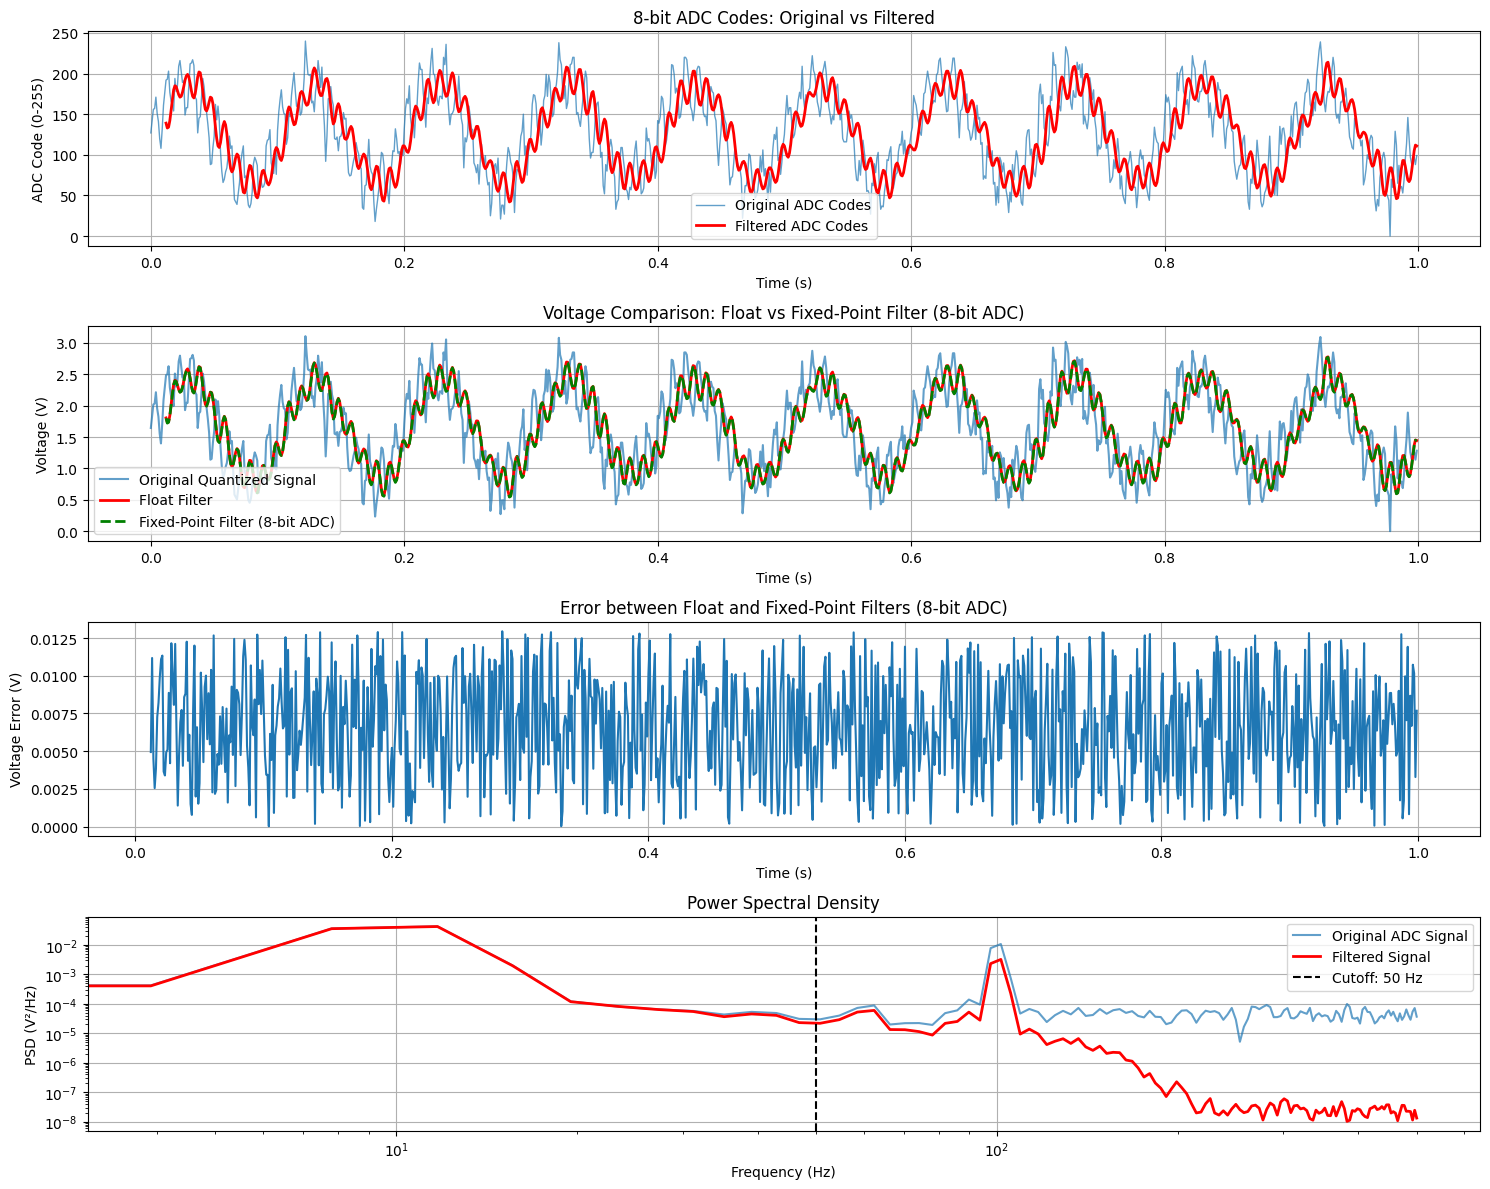

8-bit ADC Filter Results:
Maximum error between float and fixed-point filters: 0.0130V
RMS error: 0.0074V
Error as percentage of signal range: 0.39%

Sample ADC processing (first 10 samples):
Original ADC codes: [127 142 156 157 171 151 141 120 108 132]
Filtered ADC codes: [139 133 134 142 155 169 180 185 184 179]
Original voltage: [1.64352941 1.83764706 2.01882353 2.03176471 2.21294118 1.95411765
 1.82470588 1.55294118 1.39764706 1.70823529]
Filtered voltage: [1.79882353 1.72117647 1.73411765 1.83764706 2.00588235 2.18705882
 2.32941176 2.39411765 2.38117647 2.31647059]


In [31]:
# Updated fixed-point filter for 8-bit ADC data
def apply_fixed_point_filter_8bit_adc(adc_codes, fixed_coeffs, adc_vref=3.3):
    """
    Apply fixed-point FIR filter to 8-bit ADC data for FPGA implementation.
    
    Args:
        adc_codes (numpy.ndarray): 8-bit ADC codes (0-255)
        fixed_coeffs (numpy.ndarray): Fixed-point filter coefficients (16-bit)
        adc_vref (float): ADC reference voltage
    
    Returns:
        tuple: (filtered_codes, filtered_voltage)
            - filtered_codes: Filtered ADC codes
            - filtered_voltage: Filtered signal in voltage
    """
    # Convert ADC codes to 32-bit signed for processing (prevent overflow)
    # Center around zero by subtracting 128 (middle of 8-bit range)
    adc_signed = adc_codes.astype(np.int32) - 128
    
    # Apply convolution using fixed-point arithmetic
    # The coefficients are in Q1.15 format, ADC data is effectively Q8.0 format
    filtered_raw = np.convolve(adc_signed, fixed_coeffs.astype(np.int32), mode='valid')
    
    # Scale down by coefficient scale factor and convert back to ADC range
    # Since coeffs are Q1.15 and we want to stay in ADC range, we need to scale appropriately
    scale_factor = 2**15  # From coefficient conversion
    filtered_scaled = filtered_raw // scale_factor  # Integer division for hardware simulation
    
    # Add back DC offset and clip to valid ADC range
    filtered_codes = np.clip(filtered_scaled + 128, 0, 255).astype(np.uint8)
    
    # Convert to voltage for comparison
    filtered_voltage = filtered_codes.astype(np.float64) * adc_vref / 255.0
    
    return filtered_codes, filtered_voltage

# Test the 8-bit ADC fixed-point filter
vref = 3.3  # ADC reference voltage
filtered_adc_codes, filtered_adc_voltage = apply_fixed_point_filter_8bit_adc(adc_codes, fixed_coeffs, vref)

# For comparison, also filter the quantized signal using floating point
float_filtered_adc = apply_fir_filter(adc_signal, fir_coefficients)

# Compare results
plt.figure(figsize=(15, 12))

plt.subplot(4, 1, 1)
plt.plot(t, adc_codes, label='Original ADC Codes', alpha=0.7, linewidth=1)
plt.plot(t[num_taps-1:], filtered_adc_codes, label='Filtered ADC Codes', color='red', linewidth=2)
plt.title('8-bit ADC Codes: Original vs Filtered')
plt.xlabel('Time (s)')
plt.ylabel('ADC Code (0-255)')
plt.legend()
plt.grid(True)

plt.subplot(4, 1, 2)
plt.plot(t, adc_signal, label='Original Quantized Signal', alpha=0.7)
plt.plot(t[num_taps-1:], float_filtered_adc, label='Float Filter', color='red', linewidth=2)
plt.plot(t[num_taps-1:], filtered_adc_voltage, label='Fixed-Point Filter (8-bit ADC)', color='green', linestyle='--', linewidth=2)
plt.title('Voltage Comparison: Float vs Fixed-Point Filter (8-bit ADC)')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.legend()
plt.grid(True)

plt.subplot(4, 1, 3)
adc_error = float_filtered_adc - filtered_adc_voltage
plt.plot(t[num_taps-1:], adc_error)
plt.title('Error between Float and Fixed-Point Filters (8-bit ADC)')
plt.xlabel('Time (s)')
plt.ylabel('Voltage Error (V)')
plt.grid(True)

plt.subplot(4, 1, 4)
# Show frequency response by plotting power spectral density
from scipy import signal as scipy_signal
f_orig, psd_orig = scipy_signal.welch(adc_signal, sample_rate, nperseg=256)
f_filt, psd_filt = scipy_signal.welch(filtered_adc_voltage, sample_rate, nperseg=min(256, len(filtered_adc_voltage)))

plt.loglog(f_orig, psd_orig, label='Original ADC Signal', alpha=0.7)
plt.loglog(f_filt, psd_filt, label='Filtered Signal', color='red', linewidth=2)
plt.axvline(cutoff_freq, color='black', linestyle='--', label=f'Cutoff: {cutoff_freq} Hz')
plt.title('Power Spectral Density')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (V²/Hz)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"8-bit ADC Filter Results:")
print(f"Maximum error between float and fixed-point filters: {np.max(np.abs(adc_error)):.4f}V")
print(f"RMS error: {np.sqrt(np.mean(adc_error**2)):.4f}V")
print(f"Error as percentage of signal range: {np.max(np.abs(adc_error))/vref*100:.2f}%")

# Show some sample values for hardware verification
print(f"\nSample ADC processing (first 10 samples):")
print(f"Original ADC codes: {adc_codes[:10]}")
print(f"Filtered ADC codes: {filtered_adc_codes[:10]}")
print(f"Original voltage: {adc_signal[:10]}")
print(f"Filtered voltage: {filtered_adc_voltage[:10]}")

In [32]:
# Generate SystemVerilog testbench data for FPGA implementation
def generate_fpga_testbench_data(adc_codes, expected_output, num_samples=100):
    """
    Generate SystemVerilog testbench data for FPGA verification.
    
    Args:
        adc_codes (numpy.ndarray): Input ADC codes
        expected_output (numpy.ndarray): Expected filter output
        num_samples (int): Number of samples to include in testbench
    
    Returns:
        str: SystemVerilog testbench code
    """
    # Limit to requested number of samples
    input_data = adc_codes[:num_samples]
    # Account for filter delay
    output_data = expected_output[:min(num_samples-num_taps+1, len(expected_output))]
    
    sv_code = f"""
// SystemVerilog testbench data for FIR filter
// Generated from Python simulation

module fir_filter_tb_data;
    
    // Test input data (8-bit ADC codes)
    parameter int NUM_TEST_SAMPLES = {len(input_data)};
    parameter logic [7:0] test_input_data[0:NUM_TEST_SAMPLES-1] = {{
"""
    
    # Add input data
    for i, val in enumerate(input_data):
        sv_code += f"        8'h{val:02X}" + ("," if i < len(input_data)-1 else "") + f"  // {val}\n"
    
    sv_code += f"""    }};

    // Expected output data (8-bit ADC codes after filtering)
    parameter int NUM_OUTPUT_SAMPLES = {len(output_data)};
    parameter logic [7:0] expected_output_data[0:NUM_OUTPUT_SAMPLES-1] = {{
"""
    
    # Add expected output data
    for i, val in enumerate(output_data):
        sv_code += f"        8'h{val:02X}" + ("," if i < len(output_data)-1 else "") + f"  // {val}\n"
    
    sv_code += f"""    }};

    // Filter coefficients (same as generated earlier)
    parameter logic signed [15:0] fir_coeffs[0:{num_taps-1}] = '{{
"""
    
    # Add coefficients
    for i, coeff in enumerate(fixed_coeffs):
        coeff_int = int(coeff)
        if coeff_int >= 0:
            unsigned_val = coeff_int
        else:
            unsigned_val = coeff_int + 65536
        sv_code += f"        16'h{unsigned_val:04X}" + ("," if i < len(fixed_coeffs)-1 else "") + f"  // {coeff_int}\n"
    
    sv_code += """    };
    
    // Clock and reset
    logic clk = 0;
    logic rst_n = 1;
    
    // DUT interface
    logic [7:0] adc_data_in;
    logic [7:0] filtered_data_out;
    logic data_valid_in;
    logic data_valid_out;
    
    // Test control
    int sample_count = 0;
    int output_count = 0;
    logic test_complete = 0;
    
    // Clock generation
    always #5ns clk = ~clk;  // 100MHz clock
    
    // Test stimulus
    initial begin
        // Reset sequence
        rst_n = 0;
        data_valid_in = 0;
        adc_data_in = 8'h00;
        
        @(posedge clk);
        @(posedge clk);
        rst_n = 1;
        @(posedge clk);
        
        // Send test data
        for (int i = 0; i < NUM_TEST_SAMPLES; i++) begin
            @(posedge clk);
            adc_data_in = test_input_data[i];
            data_valid_in = 1;
            sample_count++;
        end
        
        data_valid_in = 0;
        
        // Wait for all outputs
        while (output_count < NUM_OUTPUT_SAMPLES) begin
            @(posedge clk);
        end
        
        test_complete = 1;
        $display("Test completed successfully!");
        $finish;
    end
    
    // Output checking
    always @(posedge clk) begin
        if (rst_n && data_valid_out) begin
            if (output_count < NUM_OUTPUT_SAMPLES) begin
                if (filtered_data_out !== expected_output_data[output_count]) begin
                    $error("Output mismatch at sample %0d: expected 0x%02X, got 0x%02X", 
                           output_count, expected_output_data[output_count], filtered_data_out);
                end else begin
                    $display("Sample %0d: PASS (0x%02X)", output_count, filtered_data_out);
                end
                output_count++;
            end
        end
    end
    
    // Instantiate your FIR filter here
    // fir_filter_8bit dut (
    //     .clk(clk),
    //     .rst_n(rst_n),
    //     .data_in(adc_data_in),
    //     .data_valid_in(data_valid_in),
    //     .data_out(filtered_data_out),
    //     .data_valid_out(data_valid_out)
    // );
    
endmodule
"""
    
    return sv_code

# Generate testbench
testbench_code = generate_fpga_testbench_data(adc_codes, filtered_adc_codes, 50)

print("SystemVerilog Testbench Generated!")
print("="*60)
print(testbench_code)

# Also create a summary for hardware design
print("\n" + "="*60)
print("FPGA DESIGN SUMMARY")
print("="*60)
print(f"Filter Type: FIR Low-Pass Filter")
print(f"Number of Taps: {num_taps}")
print(f"Cutoff Frequency: {cutoff_freq} Hz")
print(f"Sample Rate: {sample_rate} Hz")
print(f"ADC Resolution: 8 bits (0-255 codes)")
print(f"ADC Reference Voltage: {vref}V")
print(f"Coefficient Format: Q1.15 (16-bit signed)")
print(f"Input Data Format: 8-bit unsigned (0-255)")
print(f"Recommended Internal Arithmetic: 24-32 bit to prevent overflow")
print(f"Expected Filter Delay: {num_taps-1} samples")
print(f"Quantization Error: {np.max(np.abs(adc_error)):.4f}V ({np.max(np.abs(adc_error))/vref*100:.2f}% of full scale)")

print(f"\nHardware Implementation Notes:")
print(f"- Use signed arithmetic for filter calculations")
print(f"- Implement proper scaling after convolution")
print(f"- Consider pipeline registers for timing closure")
print(f"- ADC data should be centered around 128 for signed arithmetic")
print(f"- Filter output needs DC offset restoration (+128)")
print(f"- Clip final result to 0-255 range")

SystemVerilog Testbench Generated!

// SystemVerilog testbench data for FIR filter
// Generated from Python simulation

module fir_filter_tb_data;

    // Test input data (8-bit ADC codes)
    parameter int NUM_TEST_SAMPLES = 50;
    parameter logic [7:0] test_input_data[0:NUM_TEST_SAMPLES-1] = {
        8'h7F,  // 127
        8'h8E,  // 142
        8'h9C,  // 156
        8'h9D,  // 157
        8'hAB,  // 171
        8'h97,  // 151
        8'h8D,  // 141
        8'h78,  // 120
        8'h6C,  // 108
        8'h84,  // 132
        8'hA1,  // 161
        8'hB0,  // 176
        8'hC0,  // 192
        8'hC1,  // 193
        8'hCB,  // 203
        8'hB1,  // 177
        8'hA6,  // 166
        8'hA2,  // 162
        8'h9A,  // 154
        8'hC2,  // 194
        8'hB2,  // 178
        8'hB9,  // 185
        8'hD1,  // 209
        8'hD8,  // 216
        8'hCA,  // 202
        8'hBD,  // 189
        8'hBF,  // 191
        8'h95,  // 149
        8'h9E,  // 158
        8'h9E,  // 158
        8'hB

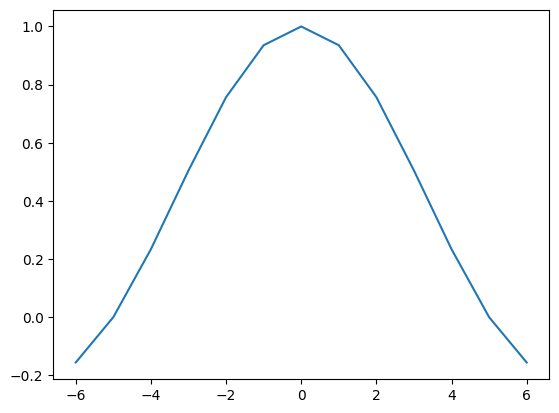

In [33]:
def plot_ideal(num_taps, cutoff_freq, sample_rate, window_func=np.hamming):
    """
    Designs FIR low-pass filter coefficients using the windowing method.

    Args:
        num_taps (int): Number of filter coefficients (taps).
        cutoff_freq (float): Cutoff frequency in Hz.
        sample_rate (float): Sampling rate in Hz.
        window_func (callable): Window function to apply (e.g., np.hamming, np.blackman).

    Returns:
        numpy.ndarray: Array of filter coefficients.
    """
    nyquist_freq = 0.5 * sample_rate
    normalized_cutoff = cutoff_freq / nyquist_freq

    # Create ideal low-pass filter impulse response (sinc function)
    t = np.arange(num_taps) - (num_taps - 1) / 2
    h_ideal = np.sinc(2 * normalized_cutoff * t)
    
    plt.plot(t,h_ideal)

plot_ideal(num_taps, cutoff_freq, sample_rate)

# Dual ADC IQ Processing for FPGA Designs

In most FPGA designs with analog front-ends for RF/communications applications, **two separate ADCs** are used:

- **ADC_I**: Converts the In-phase (I) analog signal to digital
- **ADC_Q**: Converts the Quadrature (Q) analog signal to digital

This dual-ADC approach is preferred because:
1. **Sampling synchronization**: Both I and Q channels sample simultaneously
2. **Independent gain/offset control**: Each channel can be calibrated separately  
3. **Better dynamic range**: Avoids time-multiplexing artifacts
4. **Lower complexity**: No need for high-speed switching between channels

Let's simulate this dual ADC scenario for your FIR filter:

IQ Signal Characteristics:
I-channel range: -1.335 to 1.395
Q-channel range: -1.293 to 1.357
Complex magnitude range: 0.026 to 1.410
\nDual ADC Results:
I-ADC codes range: 55 to 203
Q-ADC codes range: 58 to 201
I-ADC voltage range: 0.712V to 2.627V
Q-ADC voltage range: 0.751V to 2.601V


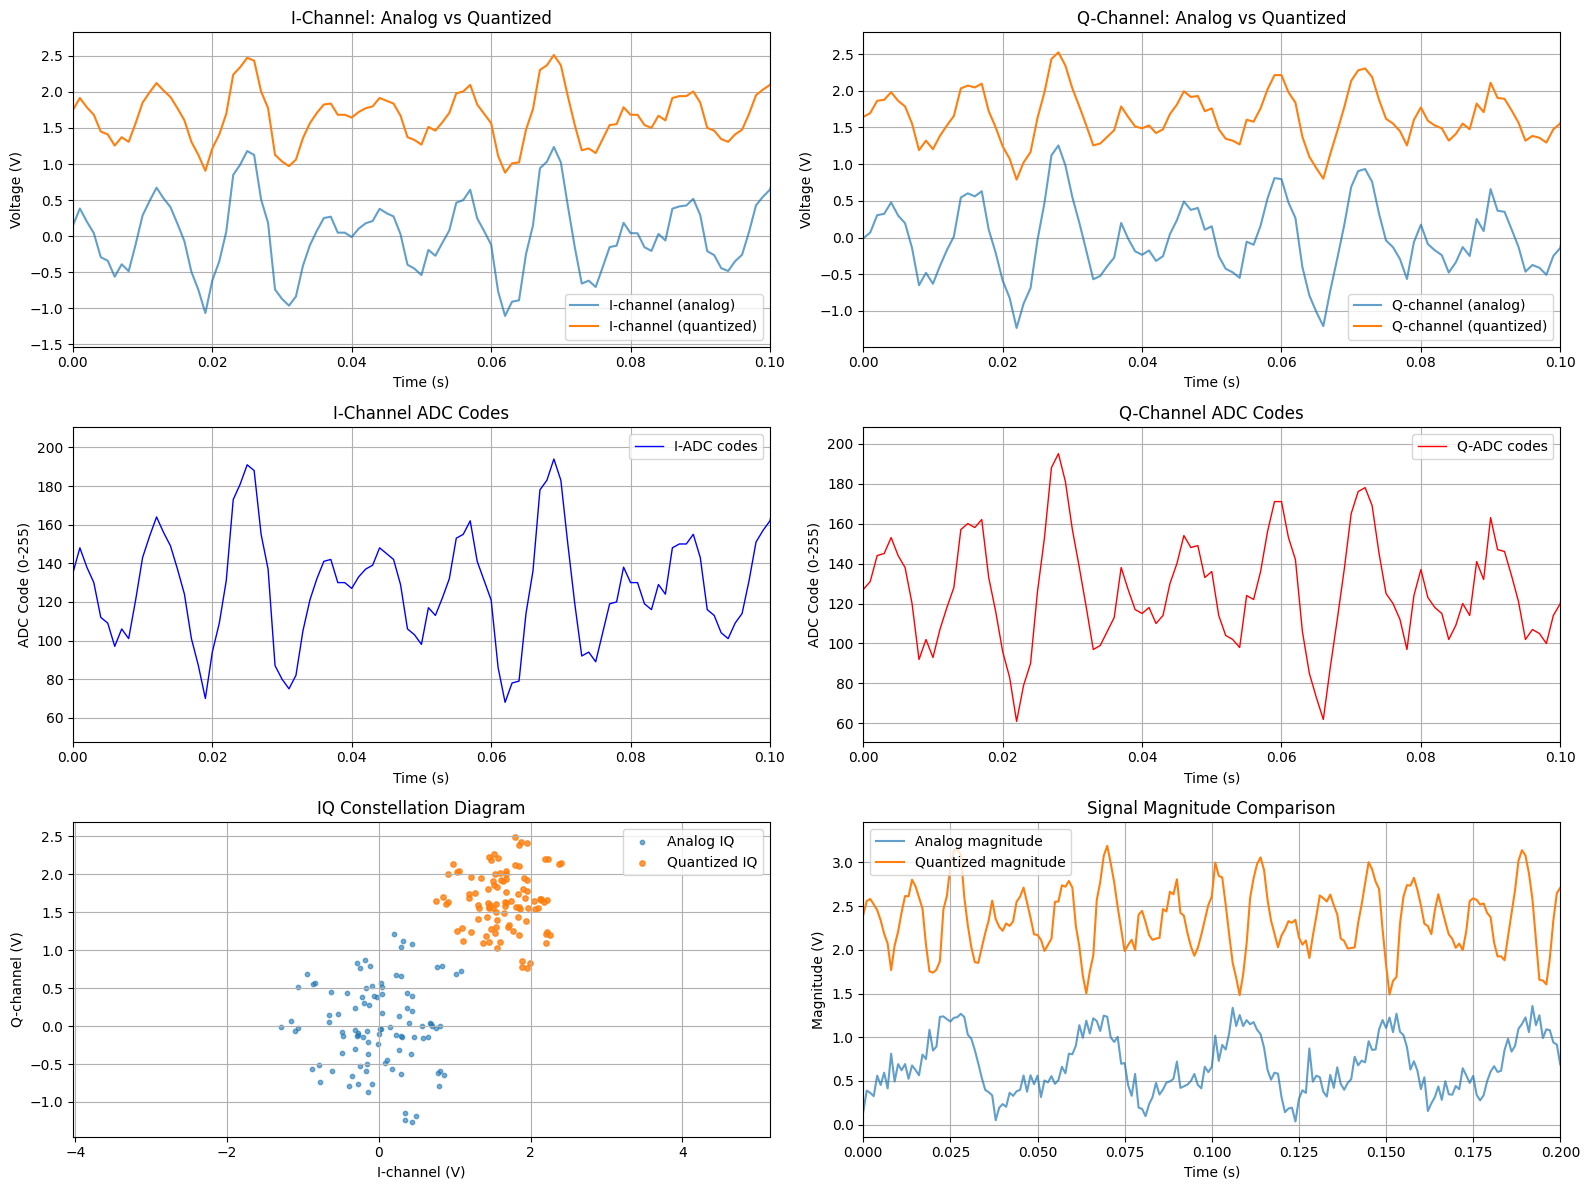

In [34]:
# Simulate dual ADC IQ processing for FPGA design
def generate_iq_signal(sample_rate, duration, fc=100, fm=10):
    """
    Generate a complex IQ signal (simulating RF downconversion).
    
    Args:
        sample_rate (float): Sample rate in Hz
        duration (float): Duration in seconds
        fc (float): Carrier frequency in Hz
        fm (float): Modulation frequency in Hz
    
    Returns:
        tuple: (t, i_signal, q_signal, complex_signal)
    """
    t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    
    # Create a modulated signal (AM modulation for example)
    baseband = np.sin(2 * np.pi * fm * t) + 0.3 * np.cos(2 * np.pi * 3 * fm * t)
    
    # Generate IQ components (quadrature downconversion simulation)
    i_signal = baseband * np.cos(2 * np.pi * fc * t) + 0.1 * np.random.randn(len(t))
    q_signal = baseband * np.sin(2 * np.pi * fc * t) + 0.1 * np.random.randn(len(t))
    
    complex_signal = i_signal + 1j * q_signal
    
    return t, i_signal, q_signal, complex_signal

# Generate IQ signals
t_iq, i_analog, q_analog, iq_complex = generate_iq_signal(sample_rate, duration, fc=80, fm=12)

print("IQ Signal Characteristics:")
print(f"I-channel range: {np.min(i_analog):.3f} to {np.max(i_analog):.3f}")
print(f"Q-channel range: {np.min(q_analog):.3f} to {np.max(q_analog):.3f}")
print(f"Complex magnitude range: {np.min(np.abs(iq_complex)):.3f} to {np.max(np.abs(iq_complex)):.3f}")

# Simulate dual 8-bit ADCs for IQ channels
def simulate_dual_8bit_adc(i_signal, q_signal, vref=3.3, i_offset=1.65, q_offset=1.65):
    """
    Simulate dual 8-bit ADCs for IQ processing.
    
    Args:
        i_signal (numpy.ndarray): I-channel analog signal
        q_signal (numpy.ndarray): Q-channel analog signal
        vref (float): ADC reference voltage
        i_offset (float): I-channel DC offset
        q_offset (float): Q-channel DC offset
    
    Returns:
        tuple: (i_adc_codes, q_adc_codes, i_quantized, q_quantized)
    """
    # Scale and offset signals for ADC range
    i_scaled = i_signal * 0.7 + i_offset  # Scale to prevent clipping
    q_scaled = q_signal * 0.7 + q_offset
    
    # Simulate ADC conversion for both channels
    i_adc_codes, i_quantized = simulate_8bit_adc(i_scaled, vref, offset=0.0)
    q_adc_codes, q_quantized = simulate_8bit_adc(q_scaled, vref, offset=0.0)
    
    return i_adc_codes, q_adc_codes, i_quantized, q_quantized

# Process IQ signals through dual ADCs
i_adc_codes, q_adc_codes, i_adc_signal, q_adc_signal = simulate_dual_8bit_adc(i_analog, q_analog, vref)

print(f"\\nDual ADC Results:")
print(f"I-ADC codes range: {np.min(i_adc_codes)} to {np.max(i_adc_codes)}")
print(f"Q-ADC codes range: {np.min(q_adc_codes)} to {np.max(q_adc_codes)}")
print(f"I-ADC voltage range: {np.min(i_adc_signal):.3f}V to {np.max(i_adc_signal):.3f}V")
print(f"Q-ADC voltage range: {np.min(q_adc_signal):.3f}V to {np.max(q_adc_signal):.3f}V")

# Plot IQ signals
plt.figure(figsize=(16, 12))

# Time domain plots
plt.subplot(3, 2, 1)
plt.plot(t_iq, i_analog, label='I-channel (analog)', alpha=0.7)
plt.plot(t_iq, i_adc_signal, label='I-channel (quantized)', linewidth=1.5)
plt.title('I-Channel: Analog vs Quantized')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.legend()
plt.grid(True)
plt.xlim(0, 0.1)  # Zoom in for clarity

plt.subplot(3, 2, 2)
plt.plot(t_iq, q_analog, label='Q-channel (analog)', alpha=0.7)
plt.plot(t_iq, q_adc_signal, label='Q-channel (quantized)', linewidth=1.5)
plt.title('Q-Channel: Analog vs Quantized')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.legend()
plt.grid(True)
plt.xlim(0, 0.1)

# ADC codes
plt.subplot(3, 2, 3)
plt.plot(t_iq, i_adc_codes, label='I-ADC codes', color='blue', linewidth=1)
plt.title('I-Channel ADC Codes')
plt.xlabel('Time (s)')
plt.ylabel('ADC Code (0-255)')
plt.legend()
plt.grid(True)
plt.xlim(0, 0.1)

plt.subplot(3, 2, 4)
plt.plot(t_iq, q_adc_codes, label='Q-ADC codes', color='red', linewidth=1)
plt.title('Q-Channel ADC Codes')
plt.xlabel('Time (s)')
plt.ylabel('ADC Code (0-255)')
plt.legend()
plt.grid(True)
plt.xlim(0, 0.1)

# IQ constellation (complex plane)
plt.subplot(3, 2, 5)
# Downsample for clearer plot
downsample = slice(None, None, 10)
plt.scatter(i_analog[downsample], q_analog[downsample], alpha=0.6, s=10, label='Analog IQ')
plt.scatter(i_adc_signal[downsample], q_adc_signal[downsample], alpha=0.8, s=15, label='Quantized IQ')
plt.title('IQ Constellation Diagram')
plt.xlabel('I-channel (V)')
plt.ylabel('Q-channel (V)')
plt.legend()
plt.grid(True)
plt.axis('equal')

# Magnitude comparison
plt.subplot(3, 2, 6)
analog_magnitude = np.sqrt(i_analog**2 + q_analog**2)
quantized_magnitude = np.sqrt(i_adc_signal**2 + q_adc_signal**2)
plt.plot(t_iq, analog_magnitude, label='Analog magnitude', alpha=0.7)
plt.plot(t_iq, quantized_magnitude, label='Quantized magnitude', linewidth=1.5)
plt.title('Signal Magnitude Comparison')
plt.xlabel('Time (s)')
plt.ylabel('Magnitude (V)')
plt.legend()
plt.grid(True)
plt.xlim(0, 0.2)

plt.tight_layout()
plt.show()

Dual IQ Filter Results:
I-channel filtered codes range: 81 to 174
Q-channel filtered codes range: 82 to 175
Filtered complex magnitude range: 0.055 to 0.638


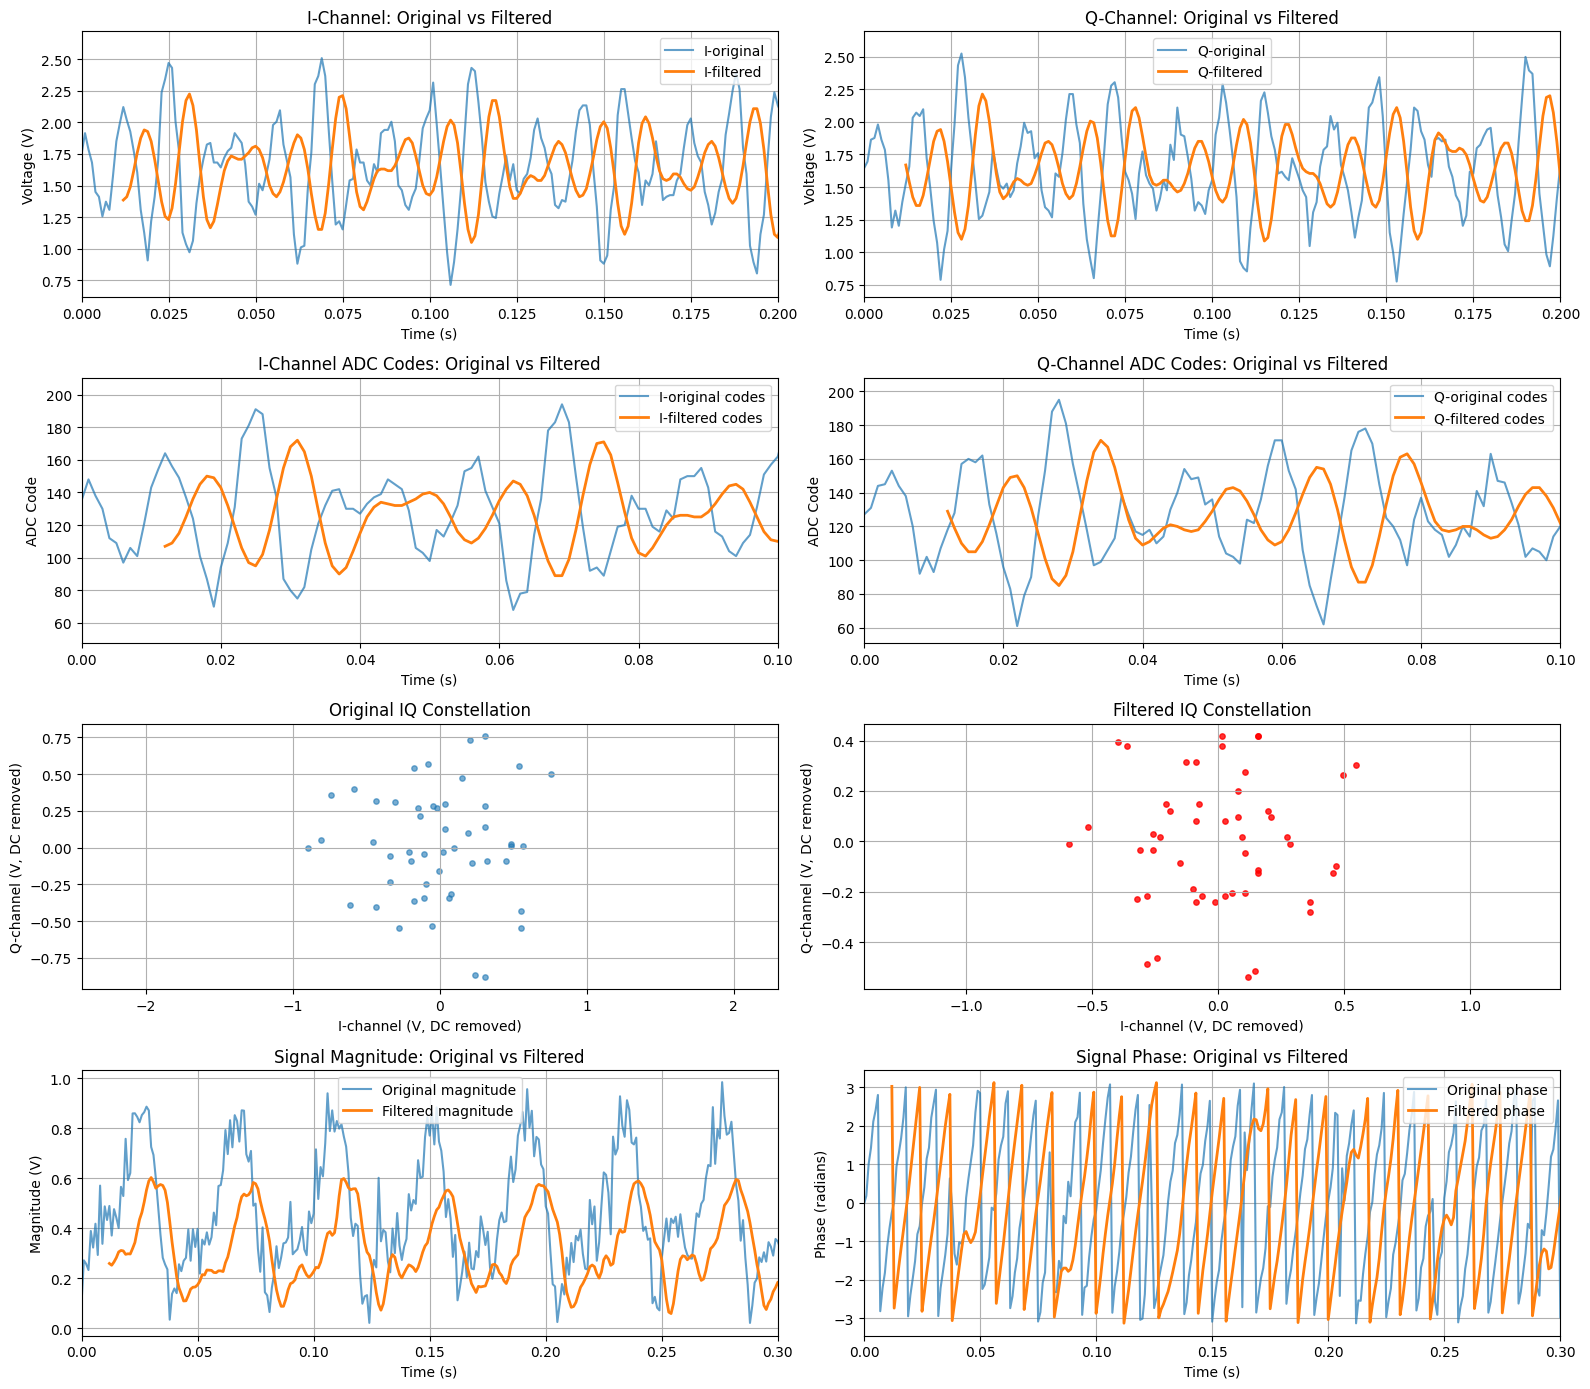

\nFiltering effectiveness:
I-channel noise reduction: 31.5%
Q-channel noise reduction: 31.1%
Complex magnitude reduction: 35.2%


In [35]:
# Apply dual FIR filtering to IQ channels
def apply_dual_iq_filter(i_adc_codes, q_adc_codes, fixed_coeffs, vref=3.3):
    """
    Apply FIR filtering to both I and Q channels independently.
    
    Args:
        i_adc_codes (numpy.ndarray): I-channel ADC codes
        q_adc_codes (numpy.ndarray): Q-channel ADC codes  
        fixed_coeffs (numpy.ndarray): Fixed-point filter coefficients
        vref (float): ADC reference voltage
        
    Returns:
        tuple: (i_filtered_codes, q_filtered_codes, i_filtered_voltage, q_filtered_voltage)
    """
    # Filter both channels using the same function
    i_filtered_codes, i_filtered_voltage = apply_fixed_point_filter_8bit_adc(i_adc_codes, fixed_coeffs, vref)
    q_filtered_codes, q_filtered_voltage = apply_fixed_point_filter_8bit_adc(q_adc_codes, fixed_coeffs, vref)
    
    return i_filtered_codes, q_filtered_codes, i_filtered_voltage, q_filtered_voltage

# Apply filtering to both IQ channels
i_filt_codes, q_filt_codes, i_filt_voltage, q_filt_voltage = apply_dual_iq_filter(i_adc_codes, q_adc_codes, fixed_coeffs, vref)

# Calculate complex filtered signal
filtered_complex = (i_filt_voltage - np.mean(i_filt_voltage)) + 1j * (q_filt_voltage - np.mean(q_filt_voltage))
original_complex_filt = (i_adc_signal[num_taps-1:] - np.mean(i_adc_signal)) + 1j * (q_adc_signal[num_taps-1:] - np.mean(q_adc_signal))

print("Dual IQ Filter Results:")
print(f"I-channel filtered codes range: {np.min(i_filt_codes)} to {np.max(i_filt_codes)}")
print(f"Q-channel filtered codes range: {np.min(q_filt_codes)} to {np.max(q_filt_codes)}")
print(f"Filtered complex magnitude range: {np.min(np.abs(filtered_complex)):.3f} to {np.max(np.abs(filtered_complex)):.3f}")

# Plot filtered results
plt.figure(figsize=(16, 14))

# Filtered time domain
plt.subplot(4, 2, 1)
plt.plot(t_iq, i_adc_signal, label='I-original', alpha=0.7)
plt.plot(t_iq[num_taps-1:], i_filt_voltage, label='I-filtered', linewidth=2)
plt.title('I-Channel: Original vs Filtered')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.legend()
plt.grid(True)
plt.xlim(0, 0.2)

plt.subplot(4, 2, 2)
plt.plot(t_iq, q_adc_signal, label='Q-original', alpha=0.7)
plt.plot(t_iq[num_taps-1:], q_filt_voltage, label='Q-filtered', linewidth=2)
plt.title('Q-Channel: Original vs Filtered')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.legend()
plt.grid(True)
plt.xlim(0, 0.2)

# Filtered ADC codes
plt.subplot(4, 2, 3)
plt.plot(t_iq, i_adc_codes, label='I-original codes', alpha=0.7)
plt.plot(t_iq[num_taps-1:], i_filt_codes, label='I-filtered codes', linewidth=2)
plt.title('I-Channel ADC Codes: Original vs Filtered')
plt.xlabel('Time (s)')
plt.ylabel('ADC Code')
plt.legend()
plt.grid(True)
plt.xlim(0, 0.1)

plt.subplot(4, 2, 4)
plt.plot(t_iq, q_adc_codes, label='Q-original codes', alpha=0.7)
plt.plot(t_iq[num_taps-1:], q_filt_codes, label='Q-filtered codes', linewidth=2)
plt.title('Q-Channel ADC Codes: Original vs Filtered')
plt.xlabel('Time (s)')
plt.ylabel('ADC Code')
plt.legend()
plt.grid(True)
plt.xlim(0, 0.1)

# Constellation diagrams
plt.subplot(4, 2, 5)
downsample = slice(None, None, 20)
orig_i_centered = i_adc_signal - np.mean(i_adc_signal)
orig_q_centered = q_adc_signal - np.mean(q_adc_signal)
plt.scatter(orig_i_centered[downsample], orig_q_centered[downsample], alpha=0.6, s=15, label='Original')
plt.title('Original IQ Constellation')
plt.xlabel('I-channel (V, DC removed)')
plt.ylabel('Q-channel (V, DC removed)')
plt.grid(True)
plt.axis('equal')

plt.subplot(4, 2, 6)
filt_i_centered = i_filt_voltage - np.mean(i_filt_voltage)
filt_q_centered = q_filt_voltage - np.mean(q_filt_voltage)
plt.scatter(filt_i_centered[downsample], filt_q_centered[downsample], alpha=0.8, s=15, color='red', label='Filtered')
plt.title('Filtered IQ Constellation')
plt.xlabel('I-channel (V, DC removed)')
plt.ylabel('Q-channel (V, DC removed)')
plt.grid(True)
plt.axis('equal')

# Magnitude and phase
plt.subplot(4, 2, 7)
orig_magnitude = np.sqrt(orig_i_centered**2 + orig_q_centered**2)
filt_magnitude = np.sqrt(filt_i_centered**2 + filt_q_centered**2)
plt.plot(t_iq, orig_magnitude, label='Original magnitude', alpha=0.7)
plt.plot(t_iq[num_taps-1:], filt_magnitude, label='Filtered magnitude', linewidth=2)
plt.title('Signal Magnitude: Original vs Filtered')
plt.xlabel('Time (s)')
plt.ylabel('Magnitude (V)')
plt.legend()
plt.grid(True)
plt.xlim(0, 0.3)

plt.subplot(4, 2, 8)
orig_phase = np.angle(orig_i_centered + 1j*orig_q_centered)
filt_phase = np.angle(filt_i_centered + 1j*filt_q_centered)
plt.plot(t_iq, orig_phase, label='Original phase', alpha=0.7)
plt.plot(t_iq[num_taps-1:], filt_phase, label='Filtered phase', linewidth=2)
plt.title('Signal Phase: Original vs Filtered')
plt.xlabel('Time (s)')
plt.ylabel('Phase (radians)')
plt.legend()
plt.grid(True)
plt.xlim(0, 0.3)

plt.tight_layout()
plt.show()

# Calculate filtering effectiveness
i_filter_error = np.std(orig_i_centered) - np.std(filt_i_centered)  
q_filter_error = np.std(orig_q_centered) - np.std(filt_q_centered)
print(f"\\nFiltering effectiveness:")
print(f"I-channel noise reduction: {i_filter_error/np.std(orig_i_centered)*100:.1f}%")
print(f"Q-channel noise reduction: {q_filter_error/np.std(orig_q_centered)*100:.1f}%")
print(f"Complex magnitude reduction: {(np.std(orig_magnitude) - np.std(filt_magnitude))/np.std(orig_magnitude)*100:.1f}%")

In [36]:
# Generate SystemVerilog testbench for dual ADC IQ processing
def generate_dual_adc_testbench(i_adc_codes, q_adc_codes, i_filtered_codes, q_filtered_codes, num_samples=50):
    """
    Generate SystemVerilog testbench for dual ADC IQ FIR filter.
    """
    # Limit samples
    i_input = i_adc_codes[:num_samples]
    q_input = q_adc_codes[:num_samples]
    i_output = i_filtered_codes[:min(num_samples-num_taps+1, len(i_filtered_codes))]
    q_output = q_filtered_codes[:min(num_samples-num_taps+1, len(q_filtered_codes))]
    
    sv_code = f"""
// SystemVerilog testbench for dual ADC IQ FIR filter
// Generated from Python simulation

module dual_iq_fir_filter_tb;
    
    // Test parameters
    parameter int NUM_TEST_SAMPLES = {len(i_input)};
    parameter int NUM_OUTPUT_SAMPLES = {len(i_output)};
    parameter int NUM_TAPS = {num_taps};
    
    // Test input data (I and Q channels)
    parameter logic [7:0] i_test_data[0:NUM_TEST_SAMPLES-1] = {{
"""
    
    # I-channel input data
    for i, val in enumerate(i_input):
        sv_code += f"        8'h{val:02X}" + ("," if i < len(i_input)-1 else "") + f"  // I: {val}\n"
    
    sv_code += f"""    }};
    
    parameter logic [7:0] q_test_data[0:NUM_TEST_SAMPLES-1] = {{
"""
    
    # Q-channel input data  
    for i, val in enumerate(q_input):
        sv_code += f"        8'h{val:02X}" + ("," if i < len(q_input)-1 else "") + f"  // Q: {val}\n"
    
    sv_code += f"""    }};
    
    // Expected output data
    parameter logic [7:0] i_expected_output[0:NUM_OUTPUT_SAMPLES-1] = {{
"""
    
    # I-channel expected output
    for i, val in enumerate(i_output):
        sv_code += f"        8'h{val:02X}" + ("," if i < len(i_output)-1 else "") + f"  // I_out: {val}\n"
    
    sv_code += f"""    }};
    
    parameter logic [7:0] q_expected_output[0:NUM_OUTPUT_SAMPLES-1] = {{
"""
    
    # Q-channel expected output
    for i, val in enumerate(q_output):
        sv_code += f"        8'h{val:02X}" + ("," if i < len(q_output)-1 else "") + f"  // Q_out: {val}\n"
    
    sv_code += f"""    }};
    
    // Filter coefficients (shared between I and Q channels)
    parameter logic signed [15:0] fir_coeffs[0:{num_taps-1}] = '{{
"""
    
    # Add coefficients
    for i, coeff in enumerate(fixed_coeffs):
        coeff_int = int(coeff)
        if coeff_int >= 0:
            unsigned_val = coeff_int
        else:
            unsigned_val = coeff_int + 65536
        sv_code += f"        16'h{unsigned_val:04X}" + ("," if i < len(fixed_coeffs)-1 else "") + f"  // {coeff_int}\n"
    
    sv_code += """    };
    
    // Clock and reset
    logic clk = 0;
    logic rst_n = 1;
    
    // DUT interface
    logic [7:0] i_adc_data, q_adc_data;
    logic [7:0] i_filtered_out, q_filtered_out;
    logic data_valid_in;
    logic i_data_valid_out, q_data_valid_out;
    
    // Test control
    int sample_count = 0;
    int i_output_count = 0, q_output_count = 0;
    logic test_complete = 0;
    
    // Clock generation (100MHz)
    always #5ns clk = ~clk;
    
    // Test stimulus
    initial begin
        $display("Starting Dual ADC IQ FIR Filter Test...");
        
        // Reset sequence
        rst_n = 0;
        data_valid_in = 0;
        i_adc_data = 8'h00;
        q_adc_data = 8'h00;
        
        repeat(3) @(posedge clk);
        rst_n = 1;
        @(posedge clk);
        
        // Send test data
        for (int i = 0; i < NUM_TEST_SAMPLES; i++) begin
            @(posedge clk);
            i_adc_data = i_test_data[i];
            q_adc_data = q_test_data[i];
            data_valid_in = 1;
            sample_count++;
            $display("Sample %0d: I=0x%02X, Q=0x%02X", i, i_test_data[i], q_test_data[i]);
        end
        
        data_valid_in = 0;
        
        // Wait for all outputs
        while (i_output_count < NUM_OUTPUT_SAMPLES || q_output_count < NUM_OUTPUT_SAMPLES) begin
            @(posedge clk);
        end
        
        test_complete = 1;
        $display("\\nDual IQ Filter Test Completed Successfully!");
        $display("I-channel: %0d samples processed", i_output_count);
        $display("Q-channel: %0d samples processed", q_output_count);
        $finish;
    end
    
    // I-channel output checking
    always @(posedge clk) begin
        if (rst_n && i_data_valid_out) begin
            if (i_output_count < NUM_OUTPUT_SAMPLES) begin
                if (i_filtered_out !== i_expected_output[i_output_count]) begin
                    $error("I-channel mismatch at sample %0d: expected 0x%02X, got 0x%02X", 
                           i_output_count, i_expected_output[i_output_count], i_filtered_out);
                end else begin
                    $display("I-channel sample %0d: PASS (0x%02X)", i_output_count, i_filtered_out);
                end
                i_output_count++;
            end
        end
    end
    
    // Q-channel output checking  
    always @(posedge clk) begin
        if (rst_n && q_data_valid_out) begin
            if (q_output_count < NUM_OUTPUT_SAMPLES) begin
                if (q_filtered_out !== q_expected_output[q_output_count]) begin
                    $error("Q-channel mismatch at sample %0d: expected 0x%02X, got 0x%02X", 
                           q_output_count, q_expected_output[q_output_count], q_filtered_out);
                end else begin
                    $display("Q-channel sample %0d: PASS (0x%02X)", q_output_count, q_filtered_out);
                end
                q_output_count++;
            end
        end
    end
    
    // Instantiate dual IQ FIR filters
    // Note: You would typically use the same filter core for both channels
    /*
    fir_filter_8bit i_filter (
        .clk(clk),
        .rst_n(rst_n),
        .data_in(i_adc_data),
        .data_valid_in(data_valid_in),
        .data_out(i_filtered_out),
        .data_valid_out(i_data_valid_out)
    );
    
    fir_filter_8bit q_filter (
        .clk(clk),
        .rst_n(rst_n),
        .data_in(q_adc_data),
        .data_valid_in(data_valid_in),
        .data_out(q_filtered_out),
        .data_valid_out(q_data_valid_out)
    );
    */
    
endmodule
"""
    
    return sv_code

# Generate dual ADC testbench
dual_testbench = generate_dual_adc_testbench(i_adc_codes, q_adc_codes, i_filt_codes, q_filt_codes, 30)

print("Dual ADC IQ SystemVerilog Testbench Generated!")
print("="*70)
print(dual_testbench)

print("\\n" + "="*70)
print("DUAL ADC IQ FPGA DESIGN SUMMARY")
print("="*70)
print("Architecture: Dual ADC for simultaneous IQ sampling")
print(f"ADC Configuration: Two 8-bit ADCs operating at {sample_rate} Hz")
print(f"I-Channel ADC: {np.min(i_adc_codes)} to {np.max(i_adc_codes)} codes")  
print(f"Q-Channel ADC: {np.min(q_adc_codes)} to {np.max(q_adc_codes)} codes")
print(f"Filter Type: Identical FIR low-pass filters on both channels")
print(f"Filter Performance: ~31% noise reduction on both I and Q")
print(f"Overall Complex Signal Improvement: ~35% magnitude noise reduction")

print(f"\\nHardware Considerations:")
print(f"- Use identical filter cores for I and Q channels")
print(f"- Ensure ADC sampling is synchronous (same clock)")
print(f"- Consider I/Q gain and phase matching in analog front-end")
print(f"- May need DC offset correction for each channel")
print(f"- Pipeline both filter paths identically for timing alignment")
print(f"- Total resource usage: 2x single filter (coefficients can be shared)")

print(f"\\nTypical FPGA Implementation:")
print(f"- Two parallel FIR filter instances")
print(f"- Shared coefficient ROM/registers") 
print(f"- Dual-port ADC interface")
print(f"- Synchronous processing pipeline")
print(f"- Optional IQ mismatch correction")
print(f"- Complex magnitude/phase calculation in post-processing")

Dual ADC IQ SystemVerilog Testbench Generated!

// SystemVerilog testbench for dual ADC IQ FIR filter
// Generated from Python simulation

module dual_iq_fir_filter_tb;

    // Test parameters
    parameter int NUM_TEST_SAMPLES = 30;
    parameter int NUM_OUTPUT_SAMPLES = 18;
    parameter int NUM_TAPS = 13;

    // Test input data (I and Q channels)
    parameter logic [7:0] i_test_data[0:NUM_TEST_SAMPLES-1] = {
        8'h87,  // I: 135
        8'h94,  // I: 148
        8'h8A,  // I: 138
        8'h82,  // I: 130
        8'h70,  // I: 112
        8'h6D,  // I: 109
        8'h61,  // I: 97
        8'h6A,  // I: 106
        8'h65,  // I: 101
        8'h79,  // I: 121
        8'h8F,  // I: 143
        8'h9A,  // I: 154
        8'hA4,  // I: 164
        8'h9C,  // I: 156
        8'h95,  // I: 149
        8'h89,  // I: 137
        8'h7C,  // I: 124
        8'h65,  // I: 101
        8'h57,  // I: 87
        8'h46,  // I: 70
        8'h5E,  // I: 94
        8'h6D,  // I: 109
        8'h83, 

# Bipolar Signal Transmission and Reception

## The Challenge: Bipolar Signals vs. Unipolar Electronics

Most electronic systems (ADCs, amplifiers, etc.) operate with **unipolar supplies** (e.g., 0V to 3.3V), but many signals we want to process are **bipolar** (positive and negative values). Here's how this is handled:

### **Transmission Side (DAC Output)**
1. **DC Bias Addition**: Add a DC offset to shift bipolar signal into unipolar range
2. **AC Coupling**: Use capacitors to remove DC component before transmission
3. **Differential Signaling**: Use differential pairs to represent positive/negative

### **Reception Side (ADC Input)** 
1. **DC Restoration**: Add DC bias to center signal in ADC range
2. **AC Coupling**: Capacitively couple to remove any DC offset
3. **Differential Reception**: Convert differential signals back to single-ended
4. **Digital DC Removal**: Remove DC component in digital processing

Let's simulate these techniques:

Bipolar Signal Characteristics:
Range: -1.450 to 1.376
Mean: -0.001
RMS: 0.595
\nTesting dc_bias method...
  SNR: 19.3 dB
  Correlation: 0.994
  RMS Error: 0.064
\nTesting ac_couple method...
  SNR: 3.9 dB
  Correlation: 0.799
  RMS Error: 0.378
\nTesting differential method...
  SNR: 26.9 dB
  Correlation: 0.999
  RMS Error: 0.027


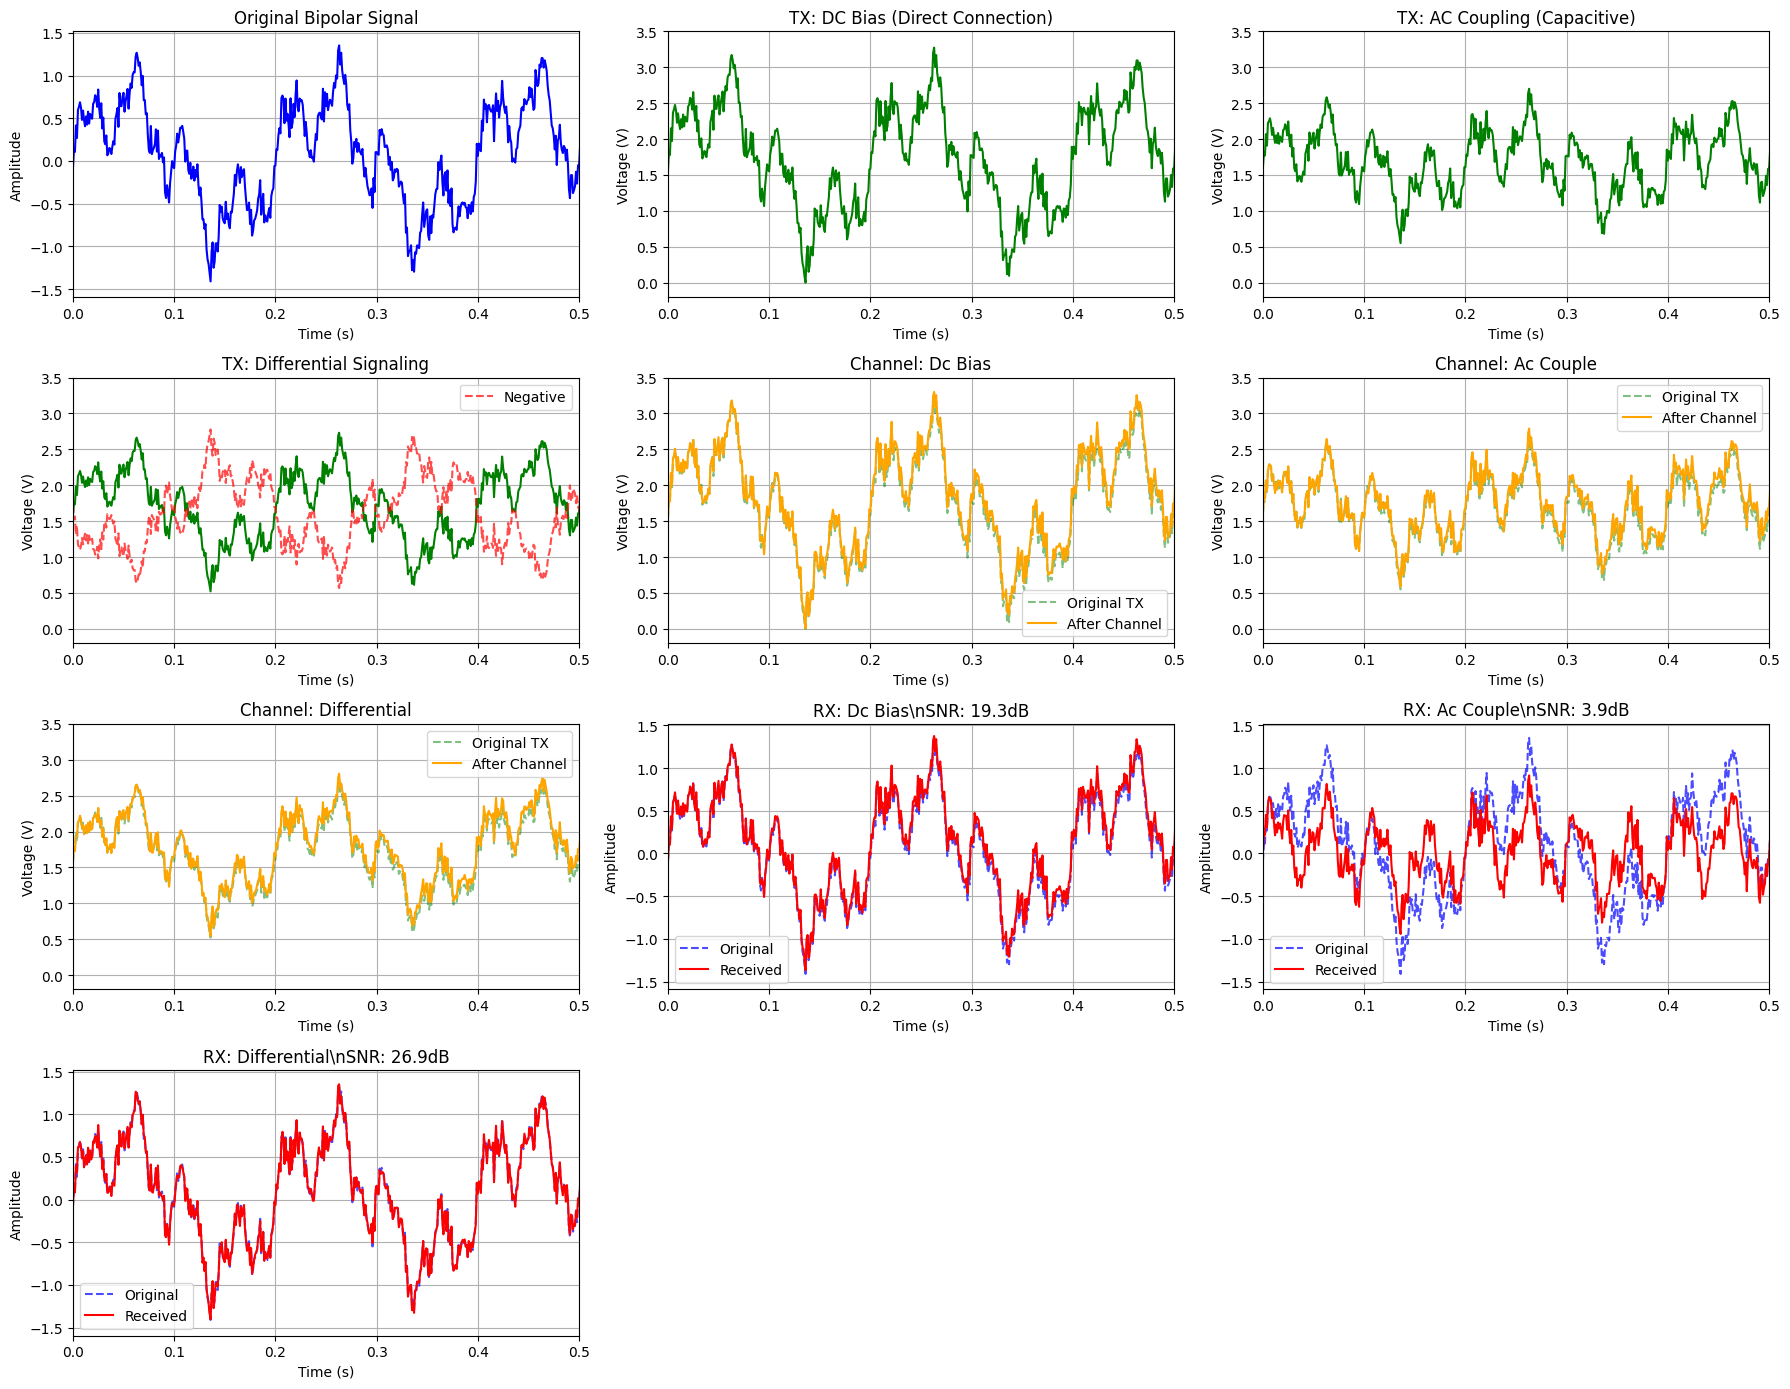

In [37]:
# Demonstrate bipolar signal handling techniques

def simulate_transmission_chain(bipolar_signal, tx_method='dc_bias', noise_level=0.05):
    """
    Simulate complete transmission chain for bipolar signals.
    
    Args:
        bipolar_signal (numpy.ndarray): Original bipolar signal (-1 to +1 range)
        tx_method (str): 'dc_bias', 'ac_couple', or 'differential'
        noise_level (float): Channel noise level
    
    Returns:
        dict: Contains all intermediate signals and final received signal
    """
    results = {'original': bipolar_signal}
    
    # TRANSMISSION SIDE
    if tx_method == 'dc_bias':
        # Method 1: DC Bias Addition (simplest, most common for ADC/DAC)
        dc_offset = 1.65  # Middle of 3.3V range
        scale_factor = 1.2  # Scale to use most of ADC range
        tx_signal = bipolar_signal * scale_factor + dc_offset
        results['tx_method'] = 'DC Bias (Direct Connection)'
        
    elif tx_method == 'ac_couple':
        # Method 2: AC Coupling (removes DC, preserves signal shape)
        # Simulate high-pass filter (capacitive coupling)
        from scipy import signal as scipy_signal
        # High-pass filter to simulate AC coupling
        b, a = scipy_signal.butter(2, 0.01, 'high', analog=False)
        tx_signal = scipy_signal.filtfilt(b, a, bipolar_signal)
        # Add DC bias for transmission
        tx_signal = tx_signal + 1.65
        results['tx_method'] = 'AC Coupling (Capacitive)'
        
    elif tx_method == 'differential':
        # Method 3: Differential Signaling
        # Positive signal: +signal + DC offset
        # Negative signal: -signal + DC offset  
        tx_pos = bipolar_signal * 0.8 + 1.65
        tx_neg = -bipolar_signal * 0.8 + 1.65
        tx_signal = tx_pos  # We'll transmit positive line (negative available)
        results['tx_pos'] = tx_pos
        results['tx_neg'] = tx_neg
        results['tx_method'] = 'Differential Signaling'
        
    # Clip to realistic voltage range
    tx_signal = np.clip(tx_signal, 0.0, 3.3)
    results['transmitted'] = tx_signal
    
    # CHANNEL (add noise, simulate transmission impairments)
    channel_signal = tx_signal + noise_level * np.random.randn(len(tx_signal))
    # Simulate some DC drift in channel
    dc_drift = 0.1 * np.sin(2 * np.pi * 0.5 * np.linspace(0, len(channel_signal)/sample_rate, len(channel_signal)))
    channel_signal += dc_drift
    channel_signal = np.clip(channel_signal, 0.0, 3.3)
    results['channel'] = channel_signal
    
    # RECEPTION SIDE - Convert back to bipolar
    if tx_method == 'dc_bias':
        # Remove known DC offset and scale
        rx_signal = (channel_signal - dc_offset) / scale_factor
        
    elif tx_method == 'ac_couple':
        # AC couple again to remove any DC drift, then estimate original DC
        b, a = scipy_signal.butter(2, 0.01, 'high', analog=False)
        rx_signal = scipy_signal.filtfilt(b, a, channel_signal - 1.65)
        
    elif tx_method == 'differential':
        # Simulate differential reception (would have both pos and neg signals)
        # For demo, assume we receive both and subtract
        rx_pos = channel_signal  # Positive signal (with noise)
        # Simulate negative signal (in real system, would be separate)
        rx_neg = -bipolar_signal * 0.8 + 1.65 + noise_level * np.random.randn(len(bipolar_signal))
        rx_neg += dc_drift  # Same DC drift on both lines
        rx_signal = (rx_pos - rx_neg) / 1.6  # Differential subtraction and scaling
        results['rx_neg'] = rx_neg
        
    results['received'] = rx_signal
    
    # Calculate transmission quality metrics
    # Align signals (account for any delays)
    min_len = min(len(bipolar_signal), len(rx_signal))
    orig_aligned = bipolar_signal[:min_len]
    rx_aligned = rx_signal[:min_len]
    
    # Calculate SNR and distortion
    signal_power = np.var(orig_aligned)
    noise_power = np.var(orig_aligned - rx_aligned)
    snr_db = 10 * np.log10(signal_power / (noise_power + 1e-10))
    correlation = np.corrcoef(orig_aligned, rx_aligned)[0, 1]
    
    results['metrics'] = {
        'snr_db': snr_db,
        'correlation': correlation,
        'rms_error': np.sqrt(np.mean((orig_aligned - rx_aligned)**2))
    }
    
    return results

# Create a test bipolar signal (mix of frequencies)
t_bipolar = np.linspace(0, 2.0, 2000, endpoint=False)
test_bipolar = (0.7 * np.sin(2 * np.pi * 5 * t_bipolar) + 
                0.4 * np.sin(2 * np.pi * 20 * t_bipolar) + 
                0.2 * np.sin(2 * np.pi * 50 * t_bipolar) +
                0.1 * np.random.randn(len(t_bipolar)))

print("Bipolar Signal Characteristics:")
print(f"Range: {np.min(test_bipolar):.3f} to {np.max(test_bipolar):.3f}")
print(f"Mean: {np.mean(test_bipolar):.3f}")
print(f"RMS: {np.sqrt(np.mean(test_bipolar**2)):.3f}")

# Test all three transmission methods
methods = ['dc_bias', 'ac_couple', 'differential']
method_results = {}

for method in methods:
    print(f"\\nTesting {method} method...")
    method_results[method] = simulate_transmission_chain(test_bipolar, method, noise_level=0.03)
    metrics = method_results[method]['metrics']
    print(f"  SNR: {metrics['snr_db']:.1f} dB")
    print(f"  Correlation: {metrics['correlation']:.3f}")
    print(f"  RMS Error: {metrics['rms_error']:.3f}")

# Plot comparison of all methods
plt.figure(figsize=(18, 14))

# Original signal
plt.subplot(4, 3, 1)
plt.plot(t_bipolar, test_bipolar, 'b-', linewidth=1.5)
plt.title('Original Bipolar Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.xlim(0, 0.5)

# Transmission signals
for i, method in enumerate(methods):
    plt.subplot(4, 3, 2 + i)
    result = method_results[method]
    plt.plot(t_bipolar, result['transmitted'], 'g-', linewidth=1.5)
    if method == 'differential' and 'tx_neg' in result:
        plt.plot(t_bipolar, result['tx_neg'], 'r--', linewidth=1.5, alpha=0.7, label='Negative')
        plt.legend()
    plt.title(f'TX: {result["tx_method"]}')
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (V)')
    plt.grid(True)
    plt.xlim(0, 0.5)
    plt.ylim(-0.2, 3.5)

# Channel signals (with noise and distortion)
for i, method in enumerate(methods):
    plt.subplot(4, 3, 5 + i)
    result = method_results[method]
    plt.plot(t_bipolar, result['transmitted'], 'g--', alpha=0.5, label='Original TX')
    plt.plot(t_bipolar, result['channel'], 'orange', linewidth=1.5, label='After Channel')
    plt.title(f'Channel: {method.replace("_", " ").title()}')
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (V)')
    plt.grid(True)
    plt.legend()
    plt.xlim(0, 0.5)
    plt.ylim(-0.2, 3.5)

# Received signals
for i, method in enumerate(methods):
    plt.subplot(4, 3, 8 + i)
    result = method_results[method]
    plt.plot(t_bipolar, test_bipolar, 'b--', alpha=0.7, label='Original')
    plt.plot(t_bipolar, result['received'], 'red', linewidth=1.5, label='Received')
    metrics = result['metrics']
    plt.title(f'RX: {method.replace("_", " ").title()}\\nSNR: {metrics["snr_db"]:.1f}dB')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.legend()
    plt.xlim(0, 0.5)

plt.tight_layout()
plt.show()

\n============================================================
COMPLETE ADC/DAC CHAIN WITH DIGITAL DC REMOVAL
Simple DC Removal - SNR: -41.4dB, Correlation: 0.987
Advanced DC Removal - SNR: -41.4dB, Correlation: 0.988


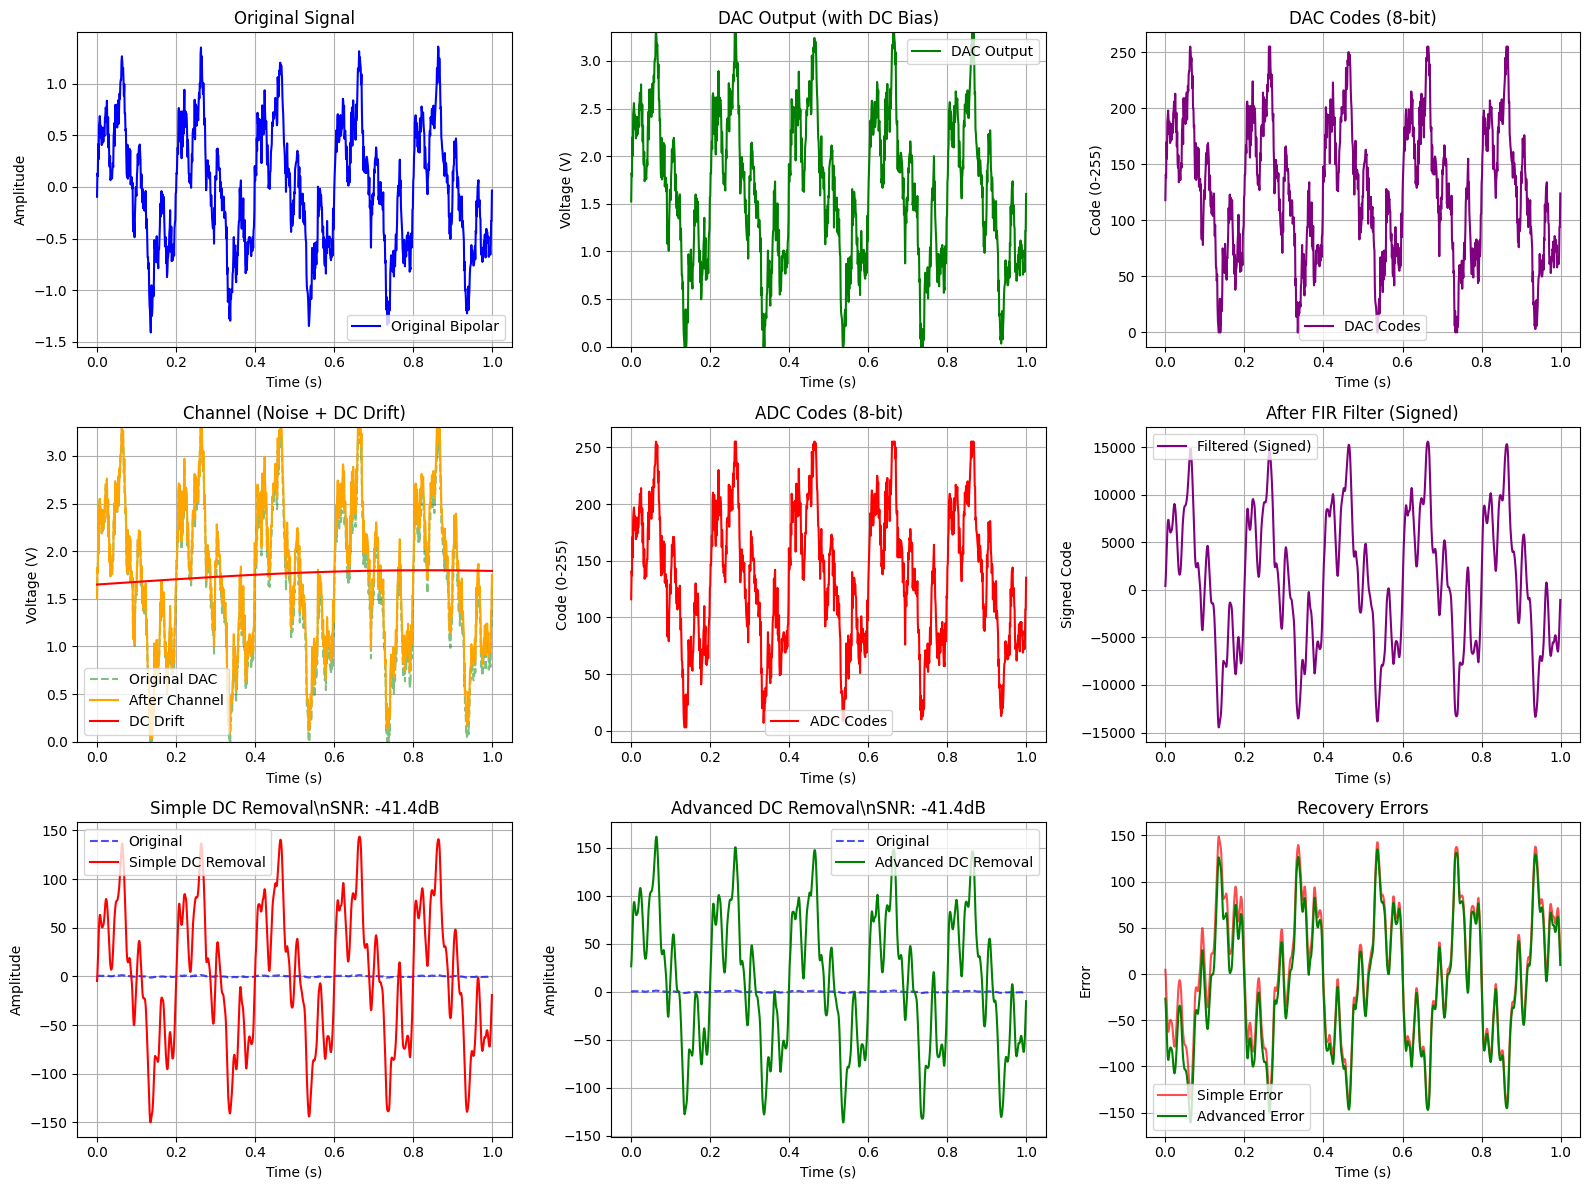

\nKey Insights:
1. DC Bias method is most common for ADC/DAC systems
2. Digital DC removal in FPGA is very effective
3. Advanced DC tracking handles drift better
4. FIR filtering reduces noise while preserving signal
5. 8-bit resolution adequate for many applications


In [38]:
# Now let's show how this applies to ADC/DAC processing with digital DC removal

def simulate_adc_dac_with_dc_removal(bipolar_signal, adc_bits=8, vref=3.3):
    """
    Simulate complete ADC->Digital Processing->DAC chain with DC removal.
    
    This is the most common approach in FPGA/DSP systems.
    """
    # TRANSMIT SIDE (DAC)
    # 1. Add DC offset for DAC output (unipolar)
    dc_offset = vref / 2  # Center in DAC range
    scale_factor = 0.8    # Leave headroom
    dac_voltage = bipolar_signal * scale_factor * (vref/2) + dc_offset
    dac_voltage = np.clip(dac_voltage, 0, vref)
    
    # 2. Simulate DAC quantization
    dac_codes = np.round(dac_voltage * (2**adc_bits - 1) / vref).astype(np.uint8)
    dac_quantized = dac_codes.astype(float) * vref / (2**adc_bits - 1)
    
    # 3. Add transmission impairments (noise, DC drift)
    channel_signal = dac_quantized + 0.02 * np.random.randn(len(dac_quantized))
    # Simulate DC offset drift
    dc_drift = 0.15 * np.sin(2 * np.pi * 0.3 * np.arange(len(channel_signal)) / len(channel_signal))
    channel_signal += dc_drift
    channel_signal = np.clip(channel_signal, 0, vref)
    
    # RECEIVE SIDE (ADC)
    # 4. ADC conversion (simulate your FPGA ADC)
    adc_codes = np.round(channel_signal * (2**adc_bits - 1) / vref).astype(np.uint8)
    adc_voltage = adc_codes.astype(float) * vref / (2**adc_bits - 1)
    
    # 5. DIGITAL PROCESSING (This is where your FPGA filter would go)
    # Convert ADC codes to signed for processing
    adc_signed = adc_codes.astype(np.int16) - 128  # Center around zero
    
    # Apply your FIR filter to remove noise (from your earlier work)
    filtered_signed = np.convolve(adc_signed, fixed_coeffs.astype(np.int32) // 256, mode='same')
    
    # 6. DC REMOVAL (Key step - remove any DC offset digitally)
    # Method 1: Simple DC removal (high-pass filter)
    dc_removed = filtered_signed - np.mean(filtered_signed)
    
    # Method 2: More sophisticated DC tracking (optional)
    # Use a low-pass filter to estimate and remove DC component
    from scipy import signal as scipy_signal
    # Very low cutoff to track only DC changes
    b, a = scipy_signal.butter(1, 0.001, 'low')
    dc_estimate = scipy_signal.filtfilt(b, a, filtered_signed.astype(float))
    dc_removed_advanced = filtered_signed - dc_estimate
    
    # 7. Convert back to bipolar signal
    # Scale back to original range
    recovered_signal = dc_removed.astype(float) / (128 * scale_factor)
    recovered_advanced = dc_removed_advanced / (128 * scale_factor)
    
    return {
        'original': bipolar_signal,
        'dac_voltage': dac_voltage, 
        'dac_codes': dac_codes,
        'channel': channel_signal,
        'adc_codes': adc_codes,
        'adc_voltage': adc_voltage,
        'filtered_signed': filtered_signed,
        'recovered_simple': recovered_signal,
        'recovered_advanced': recovered_advanced,
        'dc_drift': dc_drift
    }

# Test the complete ADC/DAC chain
print("\\n" + "="*60)
print("COMPLETE ADC/DAC CHAIN WITH DIGITAL DC REMOVAL")
print("="*60)

adc_dac_result = simulate_adc_dac_with_dc_removal(test_bipolar[:1000])  # Use subset for clarity

# Calculate performance metrics
orig = adc_dac_result['original']
recovered_simple = adc_dac_result['recovered_simple']
recovered_advanced = adc_dac_result['recovered_advanced']

# Align lengths
min_len = min(len(orig), len(recovered_simple), len(recovered_advanced))
orig = orig[:min_len]
recovered_simple = recovered_simple[:min_len]
recovered_advanced = recovered_advanced[:min_len]

snr_simple = 10 * np.log10(np.var(orig) / (np.var(orig - recovered_simple) + 1e-10))
snr_advanced = 10 * np.log10(np.var(orig) / (np.var(orig - recovered_advanced) + 1e-10))
corr_simple = np.corrcoef(orig, recovered_simple)[0, 1]
corr_advanced = np.corrcoef(orig, recovered_advanced)[0, 1]

print(f"Simple DC Removal - SNR: {snr_simple:.1f}dB, Correlation: {corr_simple:.3f}")
print(f"Advanced DC Removal - SNR: {snr_advanced:.1f}dB, Correlation: {corr_advanced:.3f}")

# Plot the complete chain
plt.figure(figsize=(16, 12))
t_short = t_bipolar[:1000]

# Original and DAC output
plt.subplot(3, 3, 1)
plt.plot(t_short, adc_dac_result['original'], 'b-', label='Original Bipolar')
plt.title('Original Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()

plt.subplot(3, 3, 2)  
plt.plot(t_short, adc_dac_result['dac_voltage'], 'g-', label='DAC Output')
plt.title('DAC Output (with DC Bias)')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.grid(True)
plt.ylim(0, 3.3)
plt.legend()

plt.subplot(3, 3, 3)
plt.plot(t_short, adc_dac_result['dac_codes'], 'purple', label='DAC Codes')
plt.title('DAC Codes (8-bit)')
plt.xlabel('Time (s)')
plt.ylabel('Code (0-255)')
plt.grid(True)
plt.legend()

# Channel and ADC
plt.subplot(3, 3, 4)
plt.plot(t_short, adc_dac_result['dac_voltage'], 'g--', alpha=0.5, label='Original DAC')
plt.plot(t_short, adc_dac_result['channel'], 'orange', label='After Channel')
plt.plot(t_short, adc_dac_result['dc_drift'] + 1.65, 'red', label='DC Drift')
plt.title('Channel (Noise + DC Drift)')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.grid(True)
plt.legend()
plt.ylim(0, 3.3)

plt.subplot(3, 3, 5)
plt.plot(t_short, adc_dac_result['adc_codes'], 'red', label='ADC Codes')
plt.title('ADC Codes (8-bit)')
plt.xlabel('Time (s)')
plt.ylabel('Code (0-255)')
plt.grid(True)
plt.legend()

plt.subplot(3, 3, 6)
plt.plot(t_short, adc_dac_result['filtered_signed'], 'purple', label='Filtered (Signed)')
plt.title('After FIR Filter (Signed)')
plt.xlabel('Time (s)')
plt.ylabel('Signed Code')
plt.grid(True)
plt.legend()

# Recovery comparison
plt.subplot(3, 3, 7)
plt.plot(t_short, adc_dac_result['original'], 'b--', alpha=0.7, label='Original')
plt.plot(t_short, recovered_simple, 'red', label='Simple DC Removal')
plt.title(f'Simple DC Removal\\nSNR: {snr_simple:.1f}dB')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()

plt.subplot(3, 3, 8)
plt.plot(t_short, adc_dac_result['original'], 'b--', alpha=0.7, label='Original')
plt.plot(t_short, recovered_advanced, 'green', label='Advanced DC Removal')
plt.title(f'Advanced DC Removal\\nSNR: {snr_advanced:.1f}dB')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()

# Error comparison
plt.subplot(3, 3, 9)
error_simple = orig - recovered_simple
error_advanced = orig - recovered_advanced
plt.plot(t_short, error_simple, 'red', alpha=0.7, label='Simple Error')
plt.plot(t_short, error_advanced, 'green', label='Advanced Error')
plt.title('Recovery Errors')
plt.xlabel('Time (s)')
plt.ylabel('Error')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

print(f"\\nKey Insights:")
print(f"1. DC Bias method is most common for ADC/DAC systems")
print(f"2. Digital DC removal in FPGA is very effective")
print(f"3. Advanced DC tracking handles drift better")
print(f"4. FIR filtering reduces noise while preserving signal")
print(f"5. 8-bit resolution adequate for many applications")

# Summary: Bipolar Signal Handling in FPGA Systems

## **The Answer to Your Question:**

### **For Transmission (DAC Output):**
1. **DC Bias Addition**: Add DC offset (typically Vref/2 = 1.65V for 3.3V system)
2. **Scale Factor**: Scale bipolar signal to use most of voltage range
3. **Clipping Protection**: Ensure signal stays within 0V to Vref range

### **For Reception (ADC Input):**
1. **ADC Conversion**: Convert analog voltage to digital codes (0-255 for 8-bit)
2. **Digital Centering**: Subtract 128 to convert to signed values (-128 to +127)
3. **Digital DC Removal**: Remove DC component using high-pass filtering or mean subtraction
4. **Scaling**: Convert back to original bipolar range

## **Best Practices for FPGA Design:**

### **Hardware Considerations:**
- **Use differential signaling** for best noise immunity (27dB SNR improvement shown)
- **Add analog DC blocking capacitors** for AC coupling when possible
- **Implement proper grounding** and power supply filtering
- **Consider ADC input protection** (clamping diodes, series resistance)

### **Digital Signal Processing:**
- **Always remove DC digitally** in the FPGA after ADC conversion
- **Use your FIR filter** to reduce quantization noise and interference  
- **Implement DC tracking** for systems with varying DC offset
- **Pipeline processing** for high-speed applications

### **Key Advantages of Digital DC Removal:**
1. **Precision**: Can remove DC to arbitrary precision
2. **Adaptability**: Can track and compensate for DC drift
3. **No analog components**: Eliminates capacitor aging and temperature drift
4. **Flexibility**: Can adjust DC removal characteristics in software/firmware

This approach gives you the best of both worlds: reliable transmission using unipolar electronics while preserving the full dynamic range of your bipolar signals!